# Analysis & Feature Engineering
___

#### Analysis
* 1.1 Examining individual customer data
* 1.2 Spending effects on customer
* 1.3 Feature Examination

#### Feature Engineering
* 2.1 Encoding date of each event
* 2.2 Encoding past transaction features
* 2.3 Create last transaction and amount features
* 2.4 Create offer received, viewed and related spending features
* 2.5 Mapping completed and viewed events to offer received row
* 2.6 Calculating days since last transaction
* 2.7 Various feature cleaning
* 2.8 Converting to numerical and NaN
* 2.9 Historical features
* 2.10 Column Ordering and dropping redundant features
* 2.11 Label Encoding categorical features

#### Build Features
* 3.1 Building all features from scratch
* 3.2 Testing build all

## 1. Analysis
___

In order to make a predictive model the data needs to be cleaned and restructered in a tidy format. Each row must constitute a separate observation - in this case a specific offer received by a specific customer at a specific time. Within this observation we we will need to embed customer behaviour/habits/tendancies which we can feature engineer based on past customer behaviour, e.g. spending habits, previous responses to offers.

In [1]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [2]:
import numpy as np
import os
import pandas as pd
import joblib
import progressbar
import re
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# importing scripts
%load_ext autoreload
%autoreload 2
%aimport src.data.make_dataset 
%aimport src.utilities.helper
%aimport src.features.build_features

from src.features.build_features import date_features
from src.data.make_dataset import save_file

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript.head(10)

offer_id                            person  \
0  78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
1  78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
2  78afa995795e4d85b5d9ceeca43f5fef01  78afa995795e4d85b5d9ceeca43f5fef   
3  78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
4  78afa995795e4d85b5d9ceeca43f5fef02  78afa995795e4d85b5d9ceeca43f5fef   
5  78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
6  78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
7  78afa995795e4d85b5d9ceeca43f5fef03  78afa995795e4d85b5d9ceeca43f5fef   
8  78afa995795e4d85b5d9ceeca43f5fef04  78afa995795e4d85b5d9ceeca43f5fef   
9  78afa995795e4d85b5d9ceeca43f5fef05  78afa995795e4d85b5d9ceeca43f5fef   

             event  time   age    income  signed_up  F  M  O  amount   id  \
0   offer received     0  75.0  100000.0 2017-05-09  1  0  0    0.00    g   
1     offer viewed     6  75.0  100000.0 2017-05-09  1  0  0    0.00    g   
2      transaction   132  75.0  100000.0 2017-05-09  1  0  0   19.89  NaN   
3  offer completed   132  75.0  100000.0 2017-05-09  1  0  0    0.00    g   
4      transaction   144  75.0  100000.0 2017-05-09  1  0  0   17.78  NaN   
5   offer received   168  75.0  100000.0 2017-05-09  1  0  0    0.00    j   
6     offer viewed   216  75.0  100000.0 2017-05-09  1  0  0    0.00    j   
7      transaction   222  75.0  100000.0 2017-05-09  1  0  0   19.67  NaN   
8      transaction   240  75.0  100000.0 2017-05-09  1  0  0   29.72  NaN   
9      transaction   378  75.0  100000.0 2017-05-09  1  0  0   23.93  NaN   

   rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
0       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
2       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
3       5.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
4       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
5       0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
6       0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
7       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
8       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
9       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   

   discount  informational  cum_amount  joined  offer received  offer viewed  \
0       0.0            0.0        0.00    -443               1             0   
1       0.0            0.0        0.00    -443               0             1   
2       0.0            0.0       19.89    -443               0             0   
3       0.0            0.0       19.89    -443               0             0   
4       0.0            0.0       37.67    -443               0             0   
5       0.0            1.0       37.67    -443               1             0   
6       0.0            1.0       37.67    -443               0             1   
7       0.0            0.0       57.34    -443               0             0   
8       0.0            0.0       87.06    -443               0             0   
9       0.0            0.0      110.99    -443               0             0   

   offer completed  transaction  
0                0            0  
1                0            0  
2                0            1  
3                1            0  
4                0            1  
5                0            0  
6                0            0  
7                0            1  
8                0            1  
9                0            1

### 1.1 Examining individual customer data

Currently the data is structered with each row representing an event:
* Offer received
* Offer viewed
* Transaction
* Offer completed

Taking a look at the data for the first person/customer:

In [4]:
def person_data(person):
    '''
    Displays unique customer's event history
    
    Parameters
    -----------
    person: if int then customer index as per the order in which customer appears in transcript data 
    if string then person referenced by their unique 'person' id           
    '''
    
    if type(person) == str:
        return transcript[transcript.person == person]
    return transcript[transcript.person == transcript.person.unique()[person]]

In [5]:
# Displaying event history of person 57 (person='fa7ccb17b2b14f32804d14f86ac87f04')
person_data(57)

offer_id                            person  \
1109   fa7ccb17b2b14f32804d14f86ac87f04e1  fa7ccb17b2b14f32804d14f86ac87f04   
1110   fa7ccb17b2b14f32804d14f86ac87f04e1  fa7ccb17b2b14f32804d14f86ac87f04   
1111   fa7ccb17b2b14f32804d14f86ac87f0401  fa7ccb17b2b14f32804d14f86ac87f04   
1112   fa7ccb17b2b14f32804d14f86ac87f0402  fa7ccb17b2b14f32804d14f86ac87f04   
1113   fa7ccb17b2b14f32804d14f86ac87f0403  fa7ccb17b2b14f32804d14f86ac87f04   
1114   fa7ccb17b2b14f32804d14f86ac87f04e1  fa7ccb17b2b14f32804d14f86ac87f04   
1115   fa7ccb17b2b14f32804d14f86ac87f04a1  fa7ccb17b2b14f32804d14f86ac87f04   
1116   fa7ccb17b2b14f32804d14f86ac87f0404  fa7ccb17b2b14f32804d14f86ac87f04   
1117   fa7ccb17b2b14f32804d14f86ac87f0405  fa7ccb17b2b14f32804d14f86ac87f04   
1118   fa7ccb17b2b14f32804d14f86ac87f04g1  fa7ccb17b2b14f32804d14f86ac87f04   
1119   fa7ccb17b2b14f32804d14f86ac87f04g1  fa7ccb17b2b14f32804d14f86ac87f04   
1120   fa7ccb17b2b14f32804d14f86ac87f0406  fa7ccb17b2b14f32804d14f86ac87f04   
1121   fa7ccb17b2b14f32804d14f86ac87f04g2  fa7ccb17b2b14f32804d14f86ac87f04   
1122   fa7ccb17b2b14f32804d14f86ac87f0407  fa7ccb17b2b14f32804d14f86ac87f04   
1123   fa7ccb17b2b14f32804d14f86ac87f0408  fa7ccb17b2b14f32804d14f86ac87f04   
1124   fa7ccb17b2b14f32804d14f86ac87f04h1  fa7ccb17b2b14f32804d14f86ac87f04   
1125   fa7ccb17b2b14f32804d14f86ac87f04h1  fa7ccb17b2b14f32804d14f86ac87f04   
1126   fa7ccb17b2b14f32804d14f86ac87f0409  fa7ccb17b2b14f32804d14f86ac87f04   
1127  fa7ccb17b2b14f32804d14f86ac87f04010  fa7ccb17b2b14f32804d14f86ac87f04   

                event  time   age   income  signed_up  F  M  O  amount   id  \
1109   offer received     0  38.0  66000.0 2017-02-11  0  1  0    0.00    e   
1110     offer viewed    36  38.0  66000.0 2017-02-11  0  1  0    0.00    e   
1111      transaction    48  38.0  66000.0 2017-02-11  0  1  0    3.38  NaN   
1112      transaction   102  38.0  66000.0 2017-02-11  0  1  0    2.29  NaN   
1113      transaction   156  38.0  66000.0 2017-02-11  0  1  0   12.05  NaN   
1114  offer completed   156  38.0  66000.0 2017-02-11  0  1  0    0.00    e   
1115   offer received   168  38.0  66000.0 2017-02-11  0  1  0    0.00    a   
1116      transaction   240  38.0  66000.0 2017-02-11  0  1  0    3.58  NaN   
1117      transaction   252  38.0  66000.0 2017-02-11  0  1  0    2.23  NaN   
1118   offer received   408  38.0  66000.0 2017-02-11  0  1  0    0.00    g   
1119     offer viewed   480  38.0  66000.0 2017-02-11  0  1  0    0.00    g   
1120      transaction   480  38.0  66000.0 2017-02-11  0  1  0    1.42  NaN   
1121   offer received   504  38.0  66000.0 2017-02-11  0  1  0    0.00    g   
1122      transaction   516  38.0  66000.0 2017-02-11  0  1  0    3.69  NaN   
1123      transaction   552  38.0  66000.0 2017-02-11  0  1  0    4.11  NaN   
1124   offer received   576  38.0  66000.0 2017-02-11  0  1  0    0.00    h   
1125     offer viewed   600  38.0  66000.0 2017-02-11  0  1  0    0.00    h   
1126      transaction   642  38.0  66000.0 2017-02-11  0  1  0    2.95  NaN   
1127      transaction   672  38.0  66000.0 2017-02-11  0  1  0    2.03  NaN   

      rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
1109       0.0        10.0     2.0       7.0     1.0  1.0     0.0   0.0   
1110       0.0        10.0     2.0       7.0     1.0  1.0     0.0   0.0   
1111       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
1112       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
1113       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
1114       2.0        10.0     2.0       7.0     1.0  1.0     0.0   0.0   
1115       0.0        20.0     5.0      10.0     0.0  1.0     0.0   0.0   
1116       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
1117       0.0         0.0     0.0       0.0     0.0  0.0     0.0   0.0   
1118       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1119       0.0         5.0     5.0       7.0  

Each person's data comprises of events through time measured in hours. As a type of time series problem we will need to extract features based on time.

In [6]:
# Converting time into days
transcript['time_days'] = transcript.time / 24

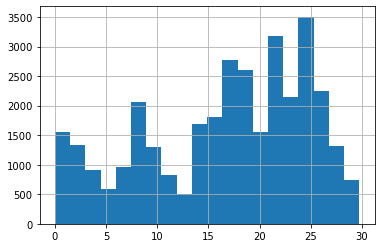

In [7]:
transcript[transcript.event == 'offer completed'].time_days.hist(bins=20);

Time_days range from zero to 30 indicating that for each customer, we have only the first 30 days of data coverage beginning when the customer first signed up with the app.  

First sign_up date:  2013-07-29 00:00:00
Last sign_up date:  2018-07-26 00:00:00


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


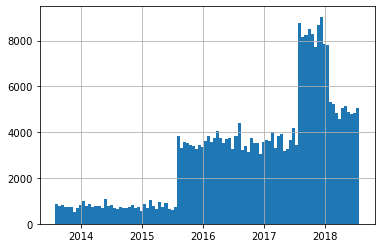

In [8]:
print('First sign_up date: ', transcript.signed_up.min())
print('Last sign_up date: ', transcript.signed_up.max())
transcript.signed_up.hist(bins=100);

Examining a histogram of number of events per year shows an increasing trend for later years, with a dip back down in 2018. <br>Since the histogram has a step shape, this is likely due to the way that the data has been sampled

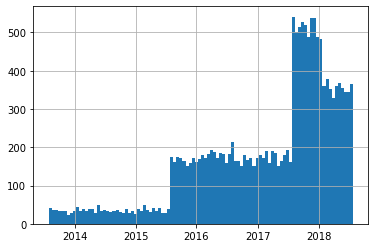

In [9]:
transcript[['person', 'signed_up']].drop_duplicates().signed_up.hist(bins=100);

Comparing this to a histogram of number of customers per year shows a similar pattern. <br> The varying number of transactions per year is therefore predominently driven by number of customers sampled not by an increasing number of events per customer.

In [10]:
def plot_person(person):
    '''
    Plots customer's event history

    Parameters
    -----------
    person: if int then customer index as per the order in which customer appears in transcript data 
    if string then person referenced by their unique 'person' id                
    '''
    x=[]
    y=[]    
    for i, event in enumerate(['transaction', 'offer received', 'offer viewed', 'offer completed']):
        # step plot of cumulative transactions
        if event=='transaction':
            x.append(person_data(person).time_days)
            y.append(person_data(person).cum_amount)               
            plt.step(x[i], y[i], alpha=.3, label=event, color='black', where='post')
            
        # scatter plot of events
        else:
            try:
                x.append(person_data(person)[person_data(person).event==event].time_days)
                y.append(person_data(person)[person_data(person).event==event].cum_amount)
                plt.scatter(x[i], y[i], alpha=.7, label=event)
            except:
                pass
            
        # required spending per time for each offer received     
        if event=='offer received':
                      
            received = person_data(person)[person_data(person).event=='offer received'][['time_days', 
                       'difficulty', 'cum_amount', 'duration']].reset_index()
            
            for i in received.index:
                x_diff = [received.iloc[i].time_days, 
                          received.iloc[i].time_days+received.iloc[i].duration]
                y_diff = [received.iloc[i].cum_amount, 
                          received.iloc[i].cum_amount+received.iloc[i].difficulty]
                plt.plot(x_diff, y_diff, color='blue', alpha=.15, linewidth='2')
    
    plt.xlabel('time(days)')
    plt.ylabel('cumulative spend')
    plt.title('Customer event history')
    plt.legend()
    plt.show()

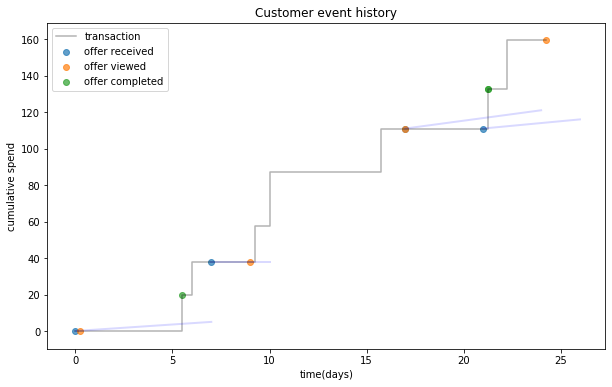

In [11]:
plt.figure(figsize=(10,6))
plot_person(0)

We can visualise any customer's 'journey' over the 30 day period by plotting cumulative transaction spend and offer events <br>
versus time.
* Offers received are indicated by blue lines representing the duration of offer validity (x-axis) vs difficulty (y-axis).
* If the customers cumulative transaction spend (visually a step function) is above the tail end of an offer received line, this indicates <br>
that the customer has spent enough during the validity period to complete the offer.

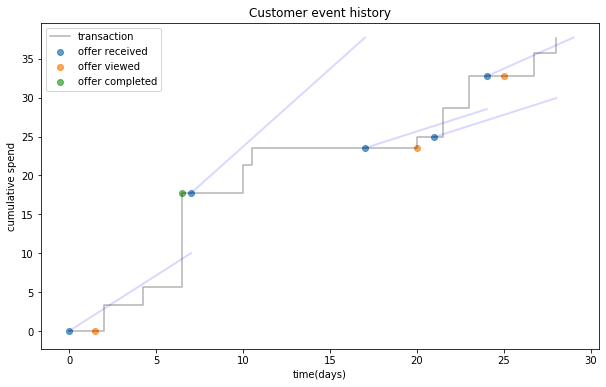

In [12]:
# Plotting customer event history of person 57 (person='fa7ccb17b2b14f32804d14f86ac87f04')
plt.figure(figsize=(10,6))
plot_person(57)

For the person in the above example we can see that the first offer ('**e**' with difficulty 10 and duration 7) was received at time <br>
zero. By day 6.5, the offer was completed with total spend during the validity period of 17.72.

In contrast, the next four offers were not completed, visually this is seen as the transaction spending step line falling below <br>
the offer received lines.

Since the customer is not aware of an offer until they view it, a key question will be to compare how much is spent <br>
during the period when the customer has knowledge of an offer vs when they do not.

Visually a customer who is responsive should have a steeper cumulative transaction spending line after an offer is viewed compared to before. <br>A completely unresponsive customer would have zero difference in rate of spending when an offer is viewed.

### 1.2 Discussion of hypothesised spending effects on a customer
We can think of the different spending effects acting on the customer as follows:

* **Base customer demographic effect** 
 * The mean tendencies of a customer based on demographic effects.
     * Age
     * Income
     * Gender


* **Individual personal customer effect**
 * Individual's spending tendancies not already captured by base demographic effects, these can be thought of as additive to the base effect.<br> 
 At any point in time we can look back at the customer's previous spending and offer response history. It is reasonable to hypothesise that <br>
 features based on history may be able to encapsulate behavioural tendancies and be predicitve of future behaviour.
   * Historical spending
   * Historical completion of offers / failures to complete
   * Degree of reactivity to an offer or level of indifference
 
 
* **Situational effects** (time dependent)
 * Offer effect - Has the customer viewed an offer and is therefore currently under its influence for the specified duration? Responsiveness to the current offer will depend on individual tendency. 
 * Previous spending effect - E.g. how much did the customer spend yesteday using the starbucks app, how about last week? Does this affect how much they will likely spend today?


* **Baseline spending**
 * If currently not under the influence of an offer, how much does the customer spend?
 
When it comes to feature engineering we will aim to encapsulate all of these effects within our models.

In [13]:
transcript

offer_id                            person  \
0       78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
1       78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
2       78afa995795e4d85b5d9ceeca43f5fef01  78afa995795e4d85b5d9ceeca43f5fef   
3       78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
4       78afa995795e4d85b5d9ceeca43f5fef02  78afa995795e4d85b5d9ceeca43f5fef   
...                                    ...                               ...   
306529  912b9f623b9e4b4eb99b6dc919f09a93c1  912b9f623b9e4b4eb99b6dc919f09a93   
306530  912b9f623b9e4b4eb99b6dc919f09a93c1  912b9f623b9e4b4eb99b6dc919f09a93   
306531  3045af4e98794a04a5542d3eac939b1fc1  3045af4e98794a04a5542d3eac939b1f   
306532  3045af4e98794a04a5542d3eac939b1fc1  3045af4e98794a04a5542d3eac939b1f   
306533  da7a7c0dcfcb41a8acc7864a53cf60fb01  da7a7c0dcfcb41a8acc7864a53cf60fb   

                  event  time   age    income  signed_up  F  M  O  amount  \
0        offer received     0  75.0  100000.0 2017-05-09  1  0  0    0.00   
1          offer viewed     6  75.0  100000.0 2017-05-09  1  0  0    0.00   
2           transaction   132  75.0  100000.0 2017-05-09  1  0  0   19.89   
3       offer completed   132  75.0  100000.0 2017-05-09  1  0  0    0.00   
4           transaction   144  75.0  100000.0 2017-05-09  1  0  0   17.78   
...                 ...   ...   ...       ...        ... .. .. ..     ...   
306529   offer received   576   NaN       NaN 2017-09-26  0  0  0    0.00   
306530     offer viewed   594   NaN       NaN 2017-09-26  0  0  0    0.00   
306531   offer received   576  58.0   78000.0 2016-10-20  1  0  0    0.00   
306532     offer viewed   576  58.0   78000.0 2016-10-20  1  0  0    0.00   
306533      transaction   582   NaN       NaN 2017-08-01  0  0  0    0.35   

         id  rewarded  difficulty  reward  duration  mobile  web  social  \
0         g       0.0         5.0     5.0       7.0     1.0  1.0     0.0   
1         g       0.0         5.0     5.0       7.0     1.0  1.0     0.0   
2       NaN       0.0         0.0     0.0       0.0     0.0  0.0     0.0   
3         g       5.0         5.0     5.0       7.0     1.0  1.0     0.0   
4       NaN       0.0         0.0     0.0       0.0     0.0  0.0     0.0   
...     ...       ...         ...     ...       ...     ...  ...     ...   
306529    c       0.0        10.0    10.0       5.0     1.0  1.0     1.0   
306530    c       0.0        10.0    10.0       5.0     1.0  1.0     1.0   
306531    c       0.0        10.0    10.0       5.0     1.0  1.0     1.0   
306532    c       0.0        10.0    10.0       5.0     1.0  1.0     1.0   
306533  NaN       0.0         0.0     0.0       0.0     0.0  0.0     0.0   

        bogo  discount  informational  cum_amount  joined  offer received  \
0        1.0       0.0            0.0        0.00    -443               1   
1        1.0       0.0            0.0        0.00    -443               0   
2        0.0       0.0            0.0       19.89    -443               0   
3        1.0       0.0            0.0       19.89    -443               0   
4        0.0       0.0            0.0       37.67    -443               0   
...      ...       ...            ...         ...     ...             ...   
306529   1.0       0.0            0.0        0.00    -303               1   
306530   1.0       0.0            0.0        0.00    -303               0   
306531   1.0       0.0            0.0        0.00    -644               1   
306532   1.0       0.0            0.0        0.00    -644               0   
306533   0.0       0.0            0.0        0.35    -359               0   

        offer viewed  offer completed  transaction  time_days  
0                  0                0            0       0.00  
1                  1                0            0       0.25  
2                  0                0            1       5.50  
3                  0                1            0    

In [61]:
import pandas_profiling

In [62]:
pandas_profiling.ProfileReport(transcript)

C:\ProgramData\Anaconda3\lib\site-packages\astropy\stats\bayesian_blocks.py:434: RuntimeWarning: divide by zero encountered in log
  return N_k * (np.log(N_k) - np.log(T_k))


### 1.3. Feature Examination

#### Event
We can see that customer purchase transactions are the most common event followed by offer received, and as expected offers viewed and completed are less frequent. 

In [14]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 6 unique specific times that offers can be received - days 0, 7, 14 , 17, 21 and 24.

In [15]:
offer_received_counts = transcript[transcript.event=='offer received'].time_days.value_counts().sort_index()
print(offer_received_counts)
print(f'mean: {offer_received_counts.mean()}  std: {offer_received_counts.std()}')

0.0     12650
7.0     12669
14.0    12711
17.0    12778
21.0    12704
24.0    12765
Name: time_days, dtype: int64
mean: 12712.833333333334  std: 50.83076496243851


We can see that there are approximately 12713 offers per time period across all customers. With an STD of only 50, these are approximately the same number of offers given per time period.

If we group by customer and plot offers received per customer:

In [16]:
customer_offer_counts = transcript[transcript.event=='offer received'].groupby('person').event.count()
print(f'Average offers received: {customer_offer_counts.mean()}')
print(customer_offer_counts.value_counts().sort_index())

Average offers received: 4.488466517594445
1      73
2     610
3    2325
4    4988
5    5931
6    3067
Name: event, dtype: int64


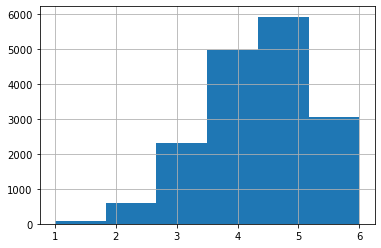

In [17]:
customer_offer_counts.hist(bins=6);

Only 73 customers received only one offer, the average was 4.49 offers per customer and the most was 6 offers given to 3067 customers.

Breaking down the offers into the specific 10 types (a to j), we can see that on average each of the offers is given 7627.7 times with SD 35.

In [18]:
total_offers_per_type = transcript[transcript.event=='offer received'].id.value_counts()
print(total_offers_per_type[:-1])
print(f'mean: {total_offers_per_type[:-1].mean()}, SD: {total_offers_per_type[:-1].std()}')

g    7677
a    7668
b    7658
f    7646
e    7632
j    7618
i    7617
d    7597
c    7593
h    7571
Name: id, dtype: int64
mean: 7627.7, SD: 34.794795268513624


Furthermore breaking down per period we see that each offer is given on average 1271 times with SD of 28. This indicates that with respect to number of offers, the dataset is balanced.

In [19]:
offer_ids_per_time = transcript[transcript.event=='offer received'].groupby('time_days').id.value_counts()
print(f'mean: {offer_ids_per_time.mean()}, SD: {offer_ids_per_time.std()}')
print(offer_ids_per_time )

mean: 1271.2833333333333, SD: 28.38840278052604
time_days  id
0.0        d     1318
           a     1297
           b     1292
           i     1273
           j     1266
           h     1263
           e     1257
           g     1245
           f     1221
           c     1218
7.0        b     1319
           g     1296
           e     1270
           j     1270
           i     1266
           h     1263
           d     1250
           f     1250
           a     1245
           c     1240
14.0       a     1322
           f     1301
           c     1280
           i     1279
           g     1275
           e     1263
           j     1256
           h     1247
           b     1245
           d     1243
17.0       e     1335
           c     1308
           j     1293
           b     1278
           i     1275
           f     1274
           g     1274
           a     1269
           h     1250
           d     1222
21.0       c     1310
           h     1305
           e  

In [20]:
for i in transcript.event.unique():
    print(f'{i}: {transcript[transcript.event==i].time_days.nunique()}')

offer received: 6
offer viewed: 120
transaction: 120
offer completed: 120


Offer viewed, transaction and offer completed have 120 possibilities. Looking at the unique values we can see that the timing of these is split into 0.25 of a day or 6 hours. This is the smallest unit of time measurement available hence 30 days * 4 = 120 unique possible values. We can assume that when an events occurs it is recorded as falling into a 6 hour time window.

In [21]:
print(np.sort(transcript[transcript.event=='offer viewed'].time_days.unique()))

[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75]


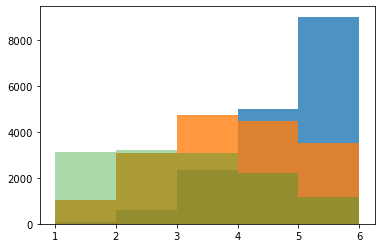

In [22]:
plt.hist(transcript[transcript.event=='offer received'].groupby('person').event.count(), bins=5, alpha=0.8)
plt.hist(transcript[transcript.event=='offer viewed'].groupby('person').event.count(), bins=5, alpha=0.8)
plt.hist(transcript[transcript.event=='offer completed'].groupby('person').event.count(), bins=5, alpha=0.4);

Plotting histograms of total events per customer

* blue:   offers received
* orange: offers viewed
* green:  offers completed 

We can see an on average decreasing funnel: <br>
Received > Viewed > Completed

This is not always strictly the case since there is also the situation of completion without having been viewed. 

#### Scatter plots - Age, Income, Joined

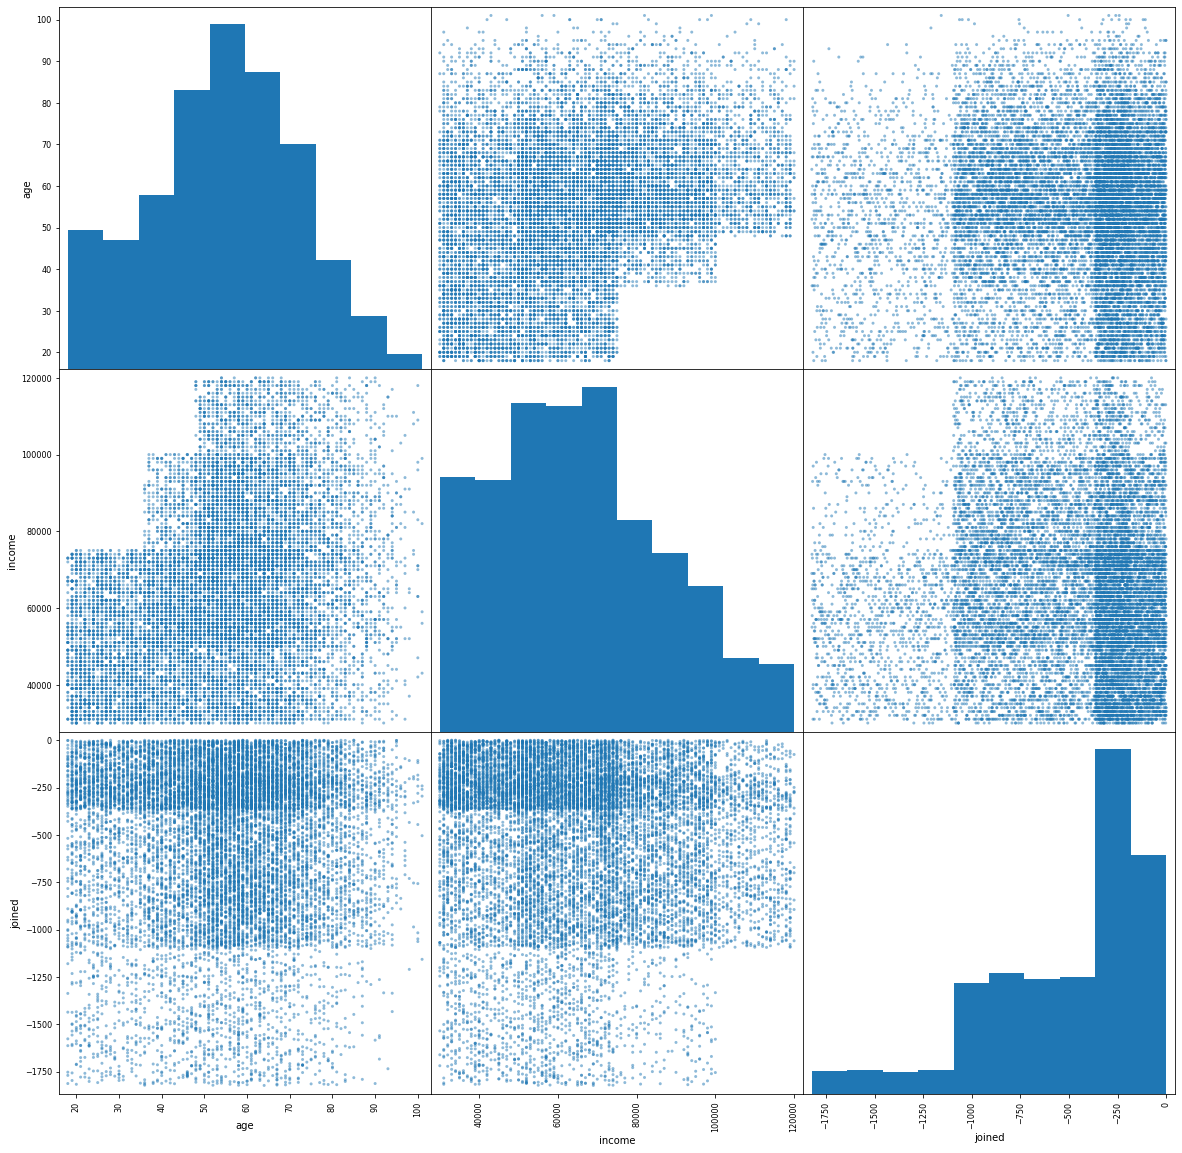

In [23]:
pd.plotting.scatter_matrix(transcript.groupby(['person'])[['age', 'income', 'joined']].mean(), figsize=(20,20));

Scatter plots of age, income and joined reveal the following patterns.

Age 
* Skewed to the right with minimum age of 18 and max 101. 
* Higher than expected number of customers at age 18 suggest some may be under aged and have selected 18 as the minimum possible.

Age vs Income
* The scatter plot appears as a blocky grid and not following a skewed normally distributed pattern as we would expect.
* We can see that there are no ages below or equal to 35 with an income over 75k.
* Similarly no ages less than or equal to 47 had an income over 100k.
* From this plot it appears that for whatever reason these potential customers have not been included in the sample process. Could it be that these might represent outliers and have been removed?

Age vs joined
* Appears normally distributed with abritrary increasing volume of customers sampled at later dates.

Income 
* Ranges from 30k to 120k, right skewed.

Income vs joined
* Again we see a blocky scatter plot suggesting dependency on the method of sampling.
* The oldest experiements (joined < 1100) do no include income above 100k. Perhaps this was the max option for the app at this time?

Joined
* Trend of increasing number of customers as time progresses.

#### Gender

In [24]:
for i in ['M', 'F', 'O']:
    print(f'{i}: {transcript.groupby("person")[i].max().sum()}')

M: 8484
F: 6129
O: 212


Comparing the above scatter plots but for male and female separately we do see a difference particularlly in the distribution of income. 
It appears there has been a greater sampling of low income males particularly the most recent customers to join.

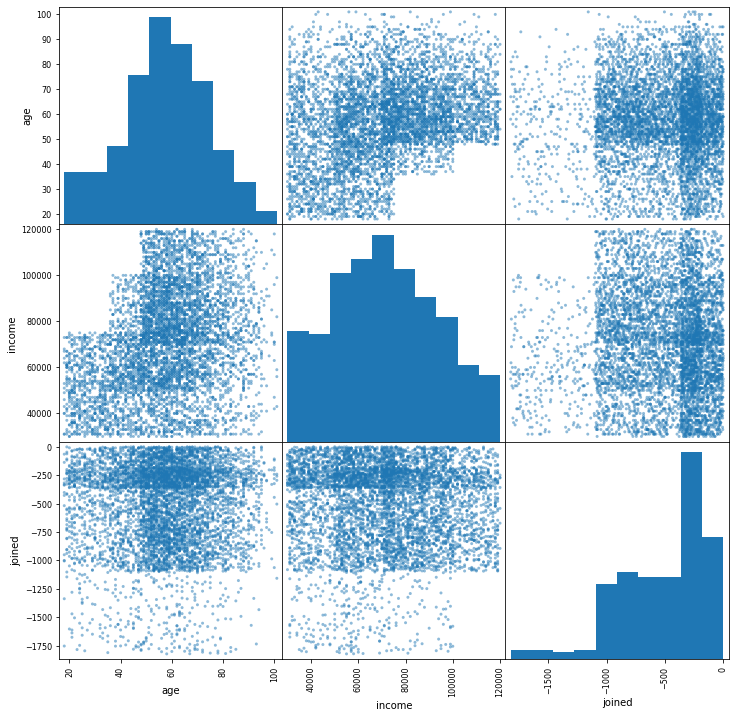

In [25]:
# Female
pd.plotting.scatter_matrix(transcript[transcript.F==1].groupby(['person'])[['age', 'income', 'joined']].mean(), figsize=(12,12));

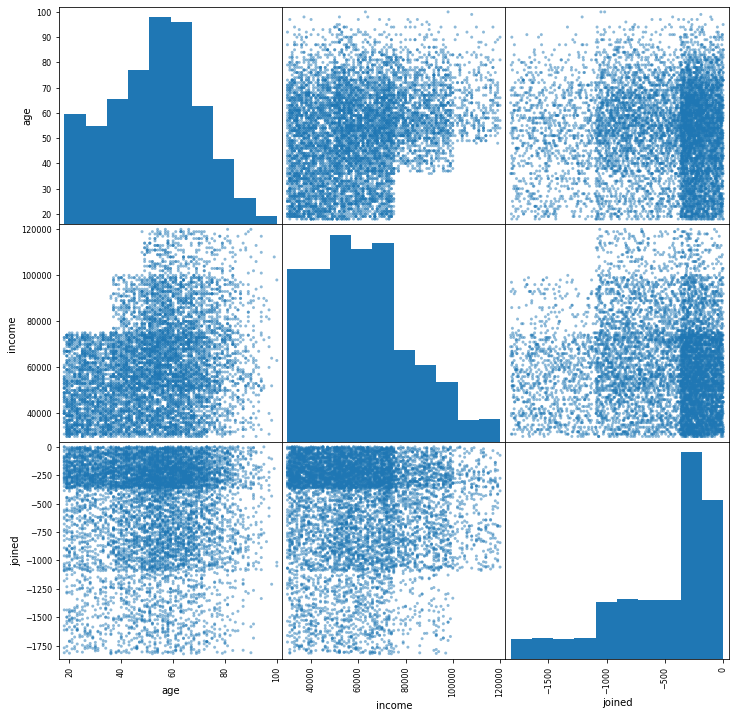

In [26]:
# Male
pd.plotting.scatter_matrix(transcript[transcript.M==1].groupby(['person'])[['age', 'income', 'joined']].mean(), figsize=(12,12));

## 2. Feature Engineering

### 2.1 Encoding date of each event

Creating new column with date of event - assuming that 0 is equal to signed up date.
* Adding day, weekday, month and year features. 
* Will later determine if these features have any predictive power

In [27]:
def date_features(transcript, save=None):
    ''' 
    Create various date/time features
    
    Parameters
    -----------
    transcript: DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim' 
    
    Returns
    -------
    DataFrame
    '''
            
    transcript['time_days'] = transcript.time / 24
    transcript['date'] = transcript.signed_up + pd.to_timedelta(transcript.time_days, unit='D')
    transcript['day'] = transcript.date.dt.day
    transcript['weekday'] = transcript.date.dt.dayofweek
    transcript['month'] = transcript.date.dt.month
    transcript['year'] = transcript.date.dt.year
    
    save_file(transcript, save) 
    
    return transcript

### 2.2 Encoding past transaction features
>Hypothesising that the previous spending habits of a customer will help predict their future spending habits. Currently transactions are listed as separate rows and will need to be mapped to one row only. We will take each offer received as an observation and map historical spending before the offer was received to buckets of total spending going back 1, 3, 7, 14, 21 and 30 days in the past. This should capture the effect of trends. The same will be done for the number of transactions since a customer's frequency of purchase may have a different effect to total spending value e.g few large purchases vs many small purchases.

In [28]:
def df_numpydict(df, df_columns):
    '''
    Converts index and specified columns of a dataframe into a dictionary of numpy arrays
    Speeds up loops.
    
    Parameters
    -----------
    df:  DataFrame
    df_columns: list of required columns names
    
    Returns
    -------
    dictionary of numpy arrays
    '''
    dict_np = {column: df[column].to_numpy() for column in df_columns}
    dict_np['index'] = df.index.to_numpy()
    return dict_np   

In [29]:
def try_join(new_data, transcript):
    '''
    Joins new_data DataFrame to transcript DataFrame
    Parameters
    -----------
    new_data: DataFrame
    transcript: DataFrame
            
    Returns
    -------
    Dataframe    
    
    '''
    try:
        transcript.drop(new_data.columns, axis=1, inplace=True)
    except:
        pass
    
    transcript = transcript.join(new_data)
    return transcript

In [30]:
def create_transaction_ranges(transcript, save=None):
    '''
    Creates time bucket fields for total transaction value and number of transactions going back in time from offer received.
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    transaction_days_range = [30,21,14,7,3,1]  
    hist = {}
    for m in transaction_days_range:
        transaction_range = f't_{m}'       
        transaction_range_count = f'{transaction_range}c'
        hist[transaction_range] = np.zeros(transcript.shape[0])
        hist[transaction_range_count] = np.zeros(transcript.shape[0])
    
    # convert required dataframe columns to dictionary of numpy arrays
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'amount'])
   
    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(t['index']):
        if t['event'][i] =='offer received':
            
            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
                if t['person'][j] != t['person'][i]:
                    break                
                
                # if transaction, how many days before offer received?
                if t['event'][j] == 'transaction':                                       
                    day_diff = t['time_days'][i] - t['time_days'][j]
                    
                    # loop through transaction day ranges and add increment transaction value and
                    # increment transaction count
                    for m in transaction_days_range:
                        transaction_range = 't_' + str(m)
                        transaction_range_count = transaction_range + 'c'
                        
                        if day_diff <= m:                            
                            hist[transaction_range][i] += t['amount'][j]
                            hist[transaction_range_count][i] += 1
                           
                        else:
                            break
                            
    new_data = pd.DataFrame(hist)[['t_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                                     't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c']]
    
    transcript = try_join(new_data, transcript)

    save_file(transcript, save)  

    return transcript

In [31]:
def overlap_offer_effect(transcript, save=None):
    '''
    Creates overlap offer feature columns [a,b,c,d,e,f,g,h,i,j] with integer value equal to the duration for which the previous offer is still valid.
        
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''              
    # convert required dataframe columns to dictionary of numpy arrays
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
    
    overlap_offer = np.empty(transcript.shape[0], dtype=str)
    overlap_offer_days = np.full(transcript.shape[0], np.nan)
            
    bar = progressbar.ProgressBar()
    for i in bar(t['index']):
        if t['event'][i] == 'offer received': 

            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
                if t['person'][j] != t['person'][i]:
                    break
                if t['event'][j] == 'offer completed':
                    break

                if t['event'][j] == 'offer received':
                    days_left = t['time_days'][j] - t['time_days'][i] + t['duration'][j]
                    
                    if days_left <= 0:
                        continue

                    overlap_offer_days[i] = days_left
                    overlap_offer[i] = t['id'][j]
                               
    offer_overlap_features = pd.get_dummies(overlap_offer, drop_first=True).mul(overlap_offer_days, axis=0).replace(0, np.nan)
    transcript = try_join(offer_overlap_features, transcript)
    
    save_file(transcript, save)  
   
    return transcript

### 2.3 Create last transaction and amount features
> Hypthothesising that the last transaction amount before an offer is viewed, and date of last transaction might affect affect liklihood of offer completion.

In [32]:
def last_transaction(transcript, save=None):
    '''
    Creates last transaction in days and last amount spent features.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'amount'])
    
    tran_index = transcript.index.to_numpy()
    tran_event = transcript.event.to_numpy()
    person = transcript.person.to_numpy()
    time = transcript.time_days.to_numpy()
    amount = transcript.amount.to_numpy()
    
    last_transaction_days = np.full(transcript.shape[0], np.nan)
    last_amount = np.full(transcript.shape[0], np.nan)

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(t['index']):
        if t['event'][i] =='offer received':
            
            # loop backwards through events of customer
            for j in t['index'][0:i][::-1]:
  
                if t['person'][j] != t['person'][i]:
                    break

                if tran_event[j] == 'transaction':
                    last_transaction_days[i] = t['time_days'][i] - t['time_days'][j]
                    last_amount[i] = amount[j]
                    break
    
    transcript['last_transaction_days'] = last_transaction_days
    transcript['last_amount'] = last_amount
            
    save_file(transcript, save)        

    return transcript

#### 2.4 Create offer received, viewed and related spending features

We do not want to target customers that would spend the required amount or a large proportion of it without viewing an offer as this will reduce profit.<br>
Our aim is to target customers that are responsive and will increase spending as soon as an offer is viewed. 

> The following features are created to assess different spending habits when an offer is received and viewed: <br>
>* **received_spend** -  How much has a customer spent towards an offer before viewing it? <br>
* **viewed_spend** - How much spending was made within the validity period after viewing an offer? <br>
* **viewed_days_left** -  How many days left to complete an offer after viewing it? <br>
* **remaining_to_complete** - How much did customer spend after viewing the offer? <br>
* **viewed_in_valid** - Did the customer actually view the offer during the valid period? <br>

In [155]:
def viewed_received_spend(transcript, save=None):
    '''
    Creates received_spend, viewed_spend, viewed_days_left, remaining_to_complete, viewed_in_valid feautures
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    t = df_numpydict(transcript, ['event', 'person', 'difficulty', 'time_days', 'duration', 'amount', 'id'])
    
    viewed_in_valid = np.zeros(transcript.shape[0])
    received_spend = np.zeros(transcript.shape[0])
    viewed_days_left = np.full(transcript.shape[0], 0.0)
    viewed_spend = np.zeros(transcript.shape[0])
    remaining_to_complete = np.full(transcript.shape[0], np.nan)
    viewed_already = np.zeros(transcript.shape[0])
        
    bar = progressbar.ProgressBar()
    for i in bar(t['index']):
        if t['event'][i] == 'offer received':

            for j in t['index'][i+1:]:                        
                
                # check if still same person
                if t['person'][j] != t['person'][i]:
                    break
                
                # check if period is within duration
                if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                    break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if t['event'][j] == 'offer viewed':
                    
                    
                
                    if (viewed_already[j] != 1) and (t['id'][i] == t['id'][j]):
                        
                        viewed_in_valid[i] = 1

                        if received_spend[i] <= t['difficulty'][i]:                        
                            viewed_days_left[i] = t['duration'][i] - (t['time_days'][j] - t['time_days'][i])
                            remaining_to_complete[i] = t['difficulty'][i] - received_spend[i]
                            if remaining_to_complete[i] < 0:
                                remaining_to_complete[i] =0
                            viewed_already[j] = 1

                        if received_spend[i] > t['difficulty'][i]:  
                            viewed_days_left[i] = 0
                            remaining_to_complete[i] = 0
                            viewed_already[j] = 1
                        
                            
                # for transactions
                if t['event'][j] == 'transaction':
                    
                    # update spending when received but not viewed      
                    if viewed_days_left[i] <=0:
                        received_spend[i] += t['amount'][j]                        
                                           
                    # update spending when viewed
                    if viewed_days_left[i] > 0:
                        viewed_spend[i] += t['amount'][j]
    
    transcript['received_spend'] = received_spend
    transcript['viewed_spend'] = viewed_spend
    transcript['viewed_days_left'] = viewed_days_left
    transcript['remaining_to_complete'] = remaining_to_complete
    transcript['viewed_in_valid'] = viewed_in_valid
    
    save_file(transcript, save)       

    return transcript

In [101]:
vv = joblib.load('../../data/interim/transcript_final_optimised_11-28_08_55_11.joblib')

In [102]:
vv2 = vv.iloc[0:100]

In [114]:
zz = viewed_received_spend(vv2)

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [115]:
zz

offer_id                            person  \
0   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
1   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
2   78afa995795e4d85b5d9ceeca43f5fef01  78afa995795e4d85b5d9ceeca43f5fef   
3   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
4   78afa995795e4d85b5d9ceeca43f5fef02  78afa995795e4d85b5d9ceeca43f5fef   
5   78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
6   78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
7   78afa995795e4d85b5d9ceeca43f5fef03  78afa995795e4d85b5d9ceeca43f5fef   
8   78afa995795e4d85b5d9ceeca43f5fef04  78afa995795e4d85b5d9ceeca43f5fef   
9   78afa995795e4d85b5d9ceeca43f5fef05  78afa995795e4d85b5d9ceeca43f5fef   
10  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
11  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
12  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
13  78afa995795e4d85b5d9ceeca43f5fef06  78afa995795e4d85b5d9ceeca43f5fef   
14  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
15  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
16  78afa995795e4d85b5d9ceeca43f5fef07  78afa995795e4d85b5d9ceeca43f5fef   
17  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
18  a03223e636434f42ac4c3df47e8bac43a1  a03223e636434f42ac4c3df47e8bac43   
19  a03223e636434f42ac4c3df47e8bac43a1  a03223e636434f42ac4c3df47e8bac43   
20  a03223e636434f42ac4c3df47e8bac4301  a03223e636434f42ac4c3df47e8bac43   
21  a03223e636434f42ac4c3df47e8bac4302  a03223e636434f42ac4c3df47e8bac43   
22  a03223e636434f42ac4c3df47e8bac43i1  a03223e636434f42ac4c3df47e8bac43   
23  a03223e636434f42ac4c3df47e8bac43i1  a03223e636434f42ac4c3df47e8bac43   
24  a03223e636434f42ac4c3df47e8bac43j1  a03223e636434f42ac4c3df47e8bac43   
25  a03223e636434f42ac4c3df47e8bac43a2  a03223e636434f42ac4c3df47e8bac43   
26  a03223e636434f42ac4c3df47e8bac43a3  a03223e636434f42ac4c3df47e8bac43   
27  a03223e636434f42ac4c3df47e8bac4303  a03223e636434f42ac4c3df47e8bac43   
28  a03223e636434f42ac4c3df47e8bac43a2  a03223e636434f42ac4c3df47e8bac43   
29  e2127556f4f64592b11af22de27a7932e1  e2127556f4f64592b11af22de27a7932   
30  e2127556f4f64592b11af22de27a7932e1  e2127556f4f64592b11af22de27a7932   
31  e2127556f4f64592b11af22de27a793201  e2127556f4f64592b11af22de27a7932   
32  e2127556f4f64592b11af22de27a793202  e2127556f4f64592b11af22de27a7932   
33  e2127556f4f64592b11af22de27a7932i1  e2127556f4f64592b11af22de27a7932   
34  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
35  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
36  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
37  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
38  e2127556f4f64592b11af22de27a793203  e2127556f4f64592b11af22de27a7932   
39  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
40  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
41  8ec6ce2a7e7949b1bf142def7d0e0586d1  8ec6ce2a7e7949b1bf142def7d0e0586   
42  8ec6ce2a7e7949b1bf142def7d0e0586d1  8ec6ce2a7e7949b1bf142def7d0e0586   
43  8ec6ce2a7e7949b1bf142def7d0e0586c1  8ec6ce2a7e7949b1bf142def7d0e0586   
44  8ec6ce2a7e7949b1bf142def7d0e0586c1  8ec6ce2a7e7949b1bf142def7d0e0586   
45  8ec6ce2a7e7949b1bf142def7d0e0586i1  8ec6ce2a7e7949b1bf142def7d0e0586   
46  8ec6ce2a7e7949b1bf142def7d0e0586i1  8ec6ce2a7e7949b1bf142def7d0e0586   
47  8ec6ce2a7e7949b1bf142def7d0e0586e1  8ec6ce2a7e7949b1bf142def7d0e0586   
48  8ec6ce2a7e7949b1bf142def7d0e0586e1  8ec6ce2a7e7949b1bf142def7d0e0586   
49  8ec6ce2a7e7949b1bf142def7d0e0586d2  8ec6ce2a7e7949b1bf142def7d0e0586   
50  8ec6ce2a7e7949b1bf142def7d0e0586d2  8ec6ce2a7e7949b1bf142def7d0e0586   
51  68617ca6246f4fbc85e91a2a49552598c1  68617ca6246f4fbc85e91a2a49552598   
52

In [104]:
zz

offer_id                            person  \
0   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
1   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
2   78afa995795e4d85b5d9ceeca43f5fef01  78afa995795e4d85b5d9ceeca43f5fef   
3   78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
4   78afa995795e4d85b5d9ceeca43f5fef02  78afa995795e4d85b5d9ceeca43f5fef   
5   78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
6   78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
7   78afa995795e4d85b5d9ceeca43f5fef03  78afa995795e4d85b5d9ceeca43f5fef   
8   78afa995795e4d85b5d9ceeca43f5fef04  78afa995795e4d85b5d9ceeca43f5fef   
9   78afa995795e4d85b5d9ceeca43f5fef05  78afa995795e4d85b5d9ceeca43f5fef   
10  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
11  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
12  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
13  78afa995795e4d85b5d9ceeca43f5fef06  78afa995795e4d85b5d9ceeca43f5fef   
14  78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
15  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
16  78afa995795e4d85b5d9ceeca43f5fef07  78afa995795e4d85b5d9ceeca43f5fef   
17  78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
18  a03223e636434f42ac4c3df47e8bac43a1  a03223e636434f42ac4c3df47e8bac43   
19  a03223e636434f42ac4c3df47e8bac43a1  a03223e636434f42ac4c3df47e8bac43   
20  a03223e636434f42ac4c3df47e8bac4301  a03223e636434f42ac4c3df47e8bac43   
21  a03223e636434f42ac4c3df47e8bac4302  a03223e636434f42ac4c3df47e8bac43   
22  a03223e636434f42ac4c3df47e8bac43i1  a03223e636434f42ac4c3df47e8bac43   
23  a03223e636434f42ac4c3df47e8bac43i1  a03223e636434f42ac4c3df47e8bac43   
24  a03223e636434f42ac4c3df47e8bac43j1  a03223e636434f42ac4c3df47e8bac43   
25  a03223e636434f42ac4c3df47e8bac43a2  a03223e636434f42ac4c3df47e8bac43   
26  a03223e636434f42ac4c3df47e8bac43a3  a03223e636434f42ac4c3df47e8bac43   
27  a03223e636434f42ac4c3df47e8bac4303  a03223e636434f42ac4c3df47e8bac43   
28  a03223e636434f42ac4c3df47e8bac43a2  a03223e636434f42ac4c3df47e8bac43   
29  e2127556f4f64592b11af22de27a7932e1  e2127556f4f64592b11af22de27a7932   
30  e2127556f4f64592b11af22de27a7932e1  e2127556f4f64592b11af22de27a7932   
31  e2127556f4f64592b11af22de27a793201  e2127556f4f64592b11af22de27a7932   
32  e2127556f4f64592b11af22de27a793202  e2127556f4f64592b11af22de27a7932   
33  e2127556f4f64592b11af22de27a7932i1  e2127556f4f64592b11af22de27a7932   
34  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
35  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
36  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
37  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
38  e2127556f4f64592b11af22de27a793203  e2127556f4f64592b11af22de27a7932   
39  e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
40  e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
41  8ec6ce2a7e7949b1bf142def7d0e0586d1  8ec6ce2a7e7949b1bf142def7d0e0586   
42  8ec6ce2a7e7949b1bf142def7d0e0586d1  8ec6ce2a7e7949b1bf142def7d0e0586   
43  8ec6ce2a7e7949b1bf142def7d0e0586c1  8ec6ce2a7e7949b1bf142def7d0e0586   
44  8ec6ce2a7e7949b1bf142def7d0e0586c1  8ec6ce2a7e7949b1bf142def7d0e0586   
45  8ec6ce2a7e7949b1bf142def7d0e0586i1  8ec6ce2a7e7949b1bf142def7d0e0586   
46  8ec6ce2a7e7949b1bf142def7d0e0586i1  8ec6ce2a7e7949b1bf142def7d0e0586   
47  8ec6ce2a7e7949b1bf142def7d0e0586e1  8ec6ce2a7e7949b1bf142def7d0e0586   
48  8ec6ce2a7e7949b1bf142def7d0e0586e1  8ec6ce2a7e7949b1bf142def7d0e0586   
49  8ec6ce2a7e7949b1bf142def7d0e0586d2  8ec6ce2a7e7949b1bf142def7d0e0586   
50  8ec6ce2a7e7949b1bf142def7d0e0586d2  8ec6ce2a7e7949b1bf142def7d0e0586   
51  68617ca6246f4fbc85e91a2a49552598c1  68617ca6246f4fbc85e91a2a49552598   
52

In [ ]:
zz[['person', 'event', 'duration', 'difficulty', 'time_days', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete']].viewed_spend.value_counts()

In [ ]:
zz[['person', 'event', 'duration', 'difficulty', 'time_days', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete']].info()

In [ ]:
zz[['person', 'event', 'duration', 'id', 'difficulty', 'time_days', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete']].iloc[30:80]

In [ ]:
zz[['person', 'event', 'duration', 'difficulty', 'time_days', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete']].iloc[30:50]

#### 2.5 Mapping completed and viewed events to offer received row

In [41]:
def match_verification(transcript, event=None):
    '''
    Helper function that validates whether total number of events(offer completed or offer viewed) from raw 
    data matches newly created 'complete' or 'viewed' feature.
    
    Parameters
    -----------
    transcript:  DataFrame
    event: string ('offer received' or 'offer completed')
    '''     
    
    if event == 'offer completed':
        eventid = 'completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
    
    raw = transcript[transcript.event == event].groupby('person').id.count()    
    calculated = transcript.groupby('person')[eventid].sum()

    # joining by id to match persons
    comparison_df = pd.DataFrame(calculated).join(raw)
    comparison_df.id.replace(np.nan,0, inplace=True)
    comparison_df[eventid].replace(np.nan,0, inplace=True)

    # Checking that there are no differences between each user
    if (comparison_df.id - comparison_df[eventid]).value_counts()[0.0] == transcript.person.nunique():
        print(event, ' mapped to offer rows correctly')
    else:
        print('some ' + event + 'mapped incorrectly, please compare:')
        display(comparison_df[comparison_df[eventid] - comparison_df.id != 0])

In [42]:
def time_buckets(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript.reset_index(inplace=True) #drop=True)   
    
    day_buckets = [7, 14, 17, 21, 24, 30]
    
    amount_buckets = [f'amount_{bucket}' for bucket in day_buckets]
    offer_buckets = [f'offer_{bucket}' for bucket in day_buckets]
           
    amount_buckets_dict = {bucket: np.zeros(transcript.shape[0]) for bucket in amount_buckets}
    offer_buckets_dict = {bucket: np.full(transcript.shape[0], '') for bucket in offer_buckets}
    
    buckets = {**amount_buckets_dict, **offer_buckets_dict}
    
    t = df_numpydict(transcript, ['person', 'time_days', 'event', 'amount', 'id'])
    
    #offers = {**offer_received_spend_dict, **offer_viwed_spend_dict, **offer_counts_dict}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
                       
            if t['person'][j] != t['person'][i]:
                break            
            
            if t['event'][j] == 'transaction':
                for k in day_buckets:
                    if t['time_days'][j] <= k:
                        amount_buckets_dict[f'amount_{k}'][i] += t['amount'][j]
                        break
            
            if t['event'][j] == 'offer received':
                for k in day_buckets:
                    if t['time_days'][j] == k:
                        offer_buckets_dict[f'offer_{k}'][i] = t['id'][j]
                        break
        
        for m,n in enumerate(day_buckets):
            if t['time_days'][i] < n:
                for z in day_buckets[m+1:]:
                    amount_buckets_dict[f'amount_{z}'][i] = np.nan
                    
    
    #return amount_buckets_dict, offer_buckets_dict
     
    for bucket in amount_buckets_dict:
        transcript[bucket] = amount_buckets_dict[bucket]
    
    for bucket in offer_buckets_dict:
        transcript[bucket] = offer_buckets_dict[bucket]
  
    save_file(transcript, save)       
    return transcript

In [43]:
def mapping_event(transcript, event=None, save=None):
    '''
    Maps the events 'offer completed' or 'offer viewed' to the corresponding 'offer received' row of the dataset
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''     
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
        
    if event == 'offer completed':
        eventid = 'completed'
        event_check = 'already_completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
        event_check = 'already_viewed'
    
    t[event_check] = np.zeros(transcript.shape[0])
    t[eventid] = np.zeros(transcript.shape[0])
    t[event + '_date'] = np.full(transcript.shape[0], np.nan)
    
    bar = progressbar.ProgressBar()

    for i in bar(t['index']):
        if t['event'][i] == 'offer received':

            for j in t['index'][i+1:]:
                
                if t[event_check][j] == 1:
                    continue
                
                # check if still same person
                if t['person'][j] != t['person'][i]:
                    break
                
                # check if period is within duration
                if event == 'offer completed':        
                    if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                        break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if t['event'][j] == event:                                       
                    
                    if t['id'][j] == t['id'][i]:
                        t[event_check][j] = 1
                        t[eventid][i] = 1
                        t[event + '_date'][i] = t['time_days'][j] 
                        break
    
    transcript[event_check] = t[event_check]
    transcript[eventid] = t[eventid]
    transcript[event + '_date'] = t[event + '_date']
       
    match_verification(transcript, event=event)
    transcript.drop([event_check], axis=1, inplace=True)
    
    save_file(transcript, save)         

    return transcript

#### 2.7 Various feature cleaning
* Dropping no longer needed features
* Calculating spending during offer period
* Added calculated completion feature (was more spent in offer period than offer difficulty)
* Filtering by only offer received row and dropping other event rows and columns

In [44]:
def feature_cleanup(transcript, save=None):
    '''
    Various features creation and redundant features dropped.
    
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # drop cumulative amount since equal to t-30
    transcript.drop(['cum_amount'], axis=1, inplace=True)
    
    # spending during offer period - to be predicted 
    transcript['offer_spend'] = transcript.received_spend + transcript.viewed_spend
    
    # adding boolean target variable to be predicted - was offer completed?
    transcript['spend>required'] = (transcript.received_spend + transcript.viewed_spend > transcript.difficulty).astype(int)
    
    # filtering event by only offer received, data now all included in this row
    transcript = transcript[transcript.event=='offer received']
    
    # dropping original event column
    transcript.drop(['event'], axis=1, inplace=True)
    
    # dropping offer_id since now each row is a unique offer
    transcript.drop(['offer_id'], axis=1, inplace=True)
    
    # dropping joined since same as signed_up
    transcript.drop('joined', axis=1, inplace=True)
    
    # removing 'amount' and 'transaction' since this data related to individual transactions
    transcript.drop(['amount', 'transaction'], axis=1, inplace=True)
    
    save_file(transcript, save) 
    return transcript

#### 2.8 Converting to numerical and NaN
* In order to run machine learning algorithm, will need to convert all features to numerical format
* Where a numerical value of zero is not representative. E.g. if there were not any previous transactions this is different from the previous transaction being zero days in the past, these are converted to NaN.
* We will be using the CatBoost classifier which is capable of handling NaN values.

In [45]:
def to_numerical_nan(transcript, save=None):
    '''
    Converts date and other features to numerical in preparation . Where zero values are not correctly descriptive, converts 
    these to NaNs.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
       
    # creating columns converting date time and time deltas to floats
    transcript['signed_up0'] = (transcript.signed_up - transcript.signed_up.max()).dt.days
    transcript['date0'] = (transcript.date - transcript.signed_up.max()).dt.days
        
    # replacing old date time and time delta columns with new float versions:
    transcript.signed_up = transcript.signed_up0
    transcript.date = transcript.date0

    # dropping interim new columns:
    transcript.drop(['signed_up0', 'date0'], axis=1, inplace=True)
        
    # replacing zeros with nulls for viewed_days_left and remaining to complete, since this value is only relevent if customer viewed offer
    #transcript.viewed_days_left[transcript.viewed_in_valid == 0] = np.nan
    transcript['remaining_to_complete'][transcript.viewed_in_valid == 0] = np.nan
    
    save_file(transcript, save) 
    return transcript

#### 2.9 Historical features
When trying to predict whether a customer given a particular offer at a particular point in time will complete, there are two possibilities. Either we have visibility of the customers previous history or it is a new customer and we do not.
Here we build historical features that try to encapsulate the customers historical offer completion behaviour. The following are historical totals that apply to a customer at a particular point in time.
* Rewards completed
* Rewards offered
* Difficulties completed
* Difficulties offered
* Number of completions
* Number of offers
* Number viewed and completed
* Number completed but not viewed
* Number of offers not completed
* Number of offers viewed
* Total spending during offer durations
* Total spending during offer periods with offer viewed


We will need to ascertain if these features add predictive power to a model

In [46]:
def historical_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    
    transcript.reset_index(inplace=True, drop=True)   
    
    hist_feature_names = ['hist_reward_completed', 
                     'hist_reward_possible', 
                     'hist_difficulty_completed', 
                     'hist_difficulty_possible',
                     'hist_previous_completed',
                     'hist_previous_offers',
                     'hist_viewed_and_completed',
                     'hist_complete_not_viewed',
                     'hist_failed_complete',
                     'hist_viewed',
                     'hist_received_spend',
                     'hist_viewed_spend']
    
    hist_features = {features: np.zeros(transcript.shape[0]) for features in hist_feature_names}
    
    t = df_numpydict(transcript, ['person', 'completed', 'reward', 'difficulty', 'viewed', 'received_spend', 'viewed_spend']) 
    
    t = {**t, **hist_features}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
            if t['person'][j] != t['person'][i]:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            if t['completed'][j] == 1: 
                t['hist_reward_completed'][i] += t['reward'][j]
                t['hist_reward_possible'][i] += t['reward'][j]
                t['hist_difficulty_completed'][i] += t['difficulty'][j]
                t['hist_difficulty_possible'][i] += t['difficulty'][j]
                t['hist_previous_completed'][i] += 1
                t['hist_previous_offers'][i] += 1
                
                # if viewed, make additions to view features:
                if t['viewed'][j] == 1: 
                    t['hist_viewed_and_completed'][i] += 1
                else:
                    t['hist_complete_not_viewed'][i] += 1
            
            # if didn't complete offer, make additions to possible features:                                        
            else:
                t['hist_reward_possible'][i] += t['reward'][j]
                t['hist_difficulty_possible'][i] += t['difficulty'][j]
                t['hist_previous_offers'][i] += 1
                t['hist_failed_complete'][i] += 1 
            
            # if viewed, make addition to viewed
            if t['viewed'][j] == 1:
                t['hist_viewed'][i] += 1
            
            # increment viewed and received spend
            t['hist_received_spend'][i] += t['received_spend'][j]
            t['hist_viewed_spend'][i] += t['viewed_spend'][j]
            
    for feature in hist_feature_names:
        transcript[feature] = t[feature]
    
    save_file(transcript, save)       
    return transcript

In [47]:
def previous_offer_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript.reset_index(inplace=True, drop=True)   
    
    offer_received_spend = [f'received_{i}' for i in list('0123456789')]  
    offer_viewed_spend = [f'viewed_{i}' for i in list('0123456789')]
    offer_counts = [f'count_{i}' for i in list('0123456789')]
    
    offer_received_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_received_spend}
    offer_viwed_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_viewed_spend}
    offer_counts_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_counts}
    
    t = df_numpydict(transcript, ['person', 'completed', 'viewed_spend', 'received_spend', 'id']) 
    
    offers = {**offer_received_spend_dict, **offer_viwed_spend_dict, **offer_counts_dict}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
            if t['person'][j] != t['person'][i]:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            
            previous_offer = t['id'][j]
            
            if offers[f'received_{previous_offer}'][i] >= 0:
                offers[f'received_{previous_offer}'][i] += t['received_spend'][j]
            else:
                offers[f'received_{previous_offer}'][i] = t['received_spend'][j]
            
            if offers[f'viewed_{previous_offer}'][i] >= 0:
                offers[f'viewed_{previous_offer}'][i] += t['viewed_spend'][j]
            else:
                offers[f'viewed_{previous_offer}'][i] = t['viewed_spend'][j]
                       
            if t['completed'][j]:
                if offers[f'count_{previous_offer}'][i] >= 1:
                    offers[f'count_{previous_offer}'][i] += 1
                else:
                    offers[f'count_{previous_offer}'][i] = 1
                            
    for offer in offers:
        transcript[offer] = offers[offer]
    
    save_file(transcript, save)       
    return transcript

#### 2.10 Column Ordering and dropping redundant features

In [144]:
def column_order(transcript, save=None):
    '''
    Removing redundant features and moving target features 'offer_spend' and 'completed'
    to last columns.
        
    Parameters
    -----------
    transcript:  DataFrame
 
    Returns
    -------
    DataFrame 
    '''
    
    transcript = transcript[['person', 'age', 'income', 'signed_up', 'gender', 'id',
                'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web',
                'social', 'bogo', 'discount', 'informational', 'time_days', 'day',
                'weekday', 'month', 'year', 't_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c', 'last_amount', 'received_spend', 
                'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 
                'viewed', 'last_transaction_days', 'spend>required',
                'hist_reward_completed', 'hist_reward_possible',
                'hist_difficulty_completed', 'hist_difficulty_possible',
                'hist_previous_completed', 'hist_previous_offers',
                'hist_viewed_and_completed', 'hist_complete_not_viewed',
                'hist_failed_complete', 'hist_viewed', 'hist_received_spend',
                'hist_viewed_spend', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',                              
                'received_0', 'received_1', 'received_2',
                'received_3', 'received_4', 'received_5', 'received_6', 'received_7',
                'received_8', 'received_9', 'viewed_0', 'viewed_1', 'viewed_2',
                'viewed_3', 'viewed_4', 'viewed_5', 'viewed_6', 'viewed_7', 'viewed_8',
                'viewed_9', 'count_0', 'count_1', 'count_2', 'count_3', 'count_4',
                'count_5', 'count_6', 'count_7', 'count_8', 'count_9',
                'amount_7', 'amount_14', 'amount_17',
                'amount_21', 'amount_24', 'amount_30', 'offer_7', 'offer_14',
                'offer_17', 'offer_21', 'offer_24', 'offer_30',
                'offer_spend', 'completed', 'percentage_offer_active', 'offer_active_count',
                'no_offer_count', 'offer_cum_amount', 'no_offer_cum_amount', 'amount_per_day_offer', 'amount_per_day_not_offer',
                #'offers_active', 
                #'start_range',
                #'end_range',
                #'viewed_days_left',
                #'amount_not_offer',
                #'amount_while_offer'                
                 ]]                
                
    
    save_file(transcript, save)
    return transcript

#### 2.11 Label Encoding categorical features
* Since the CatBoost gradient boosting algorithm that we utilise is able to handle categorical features, we should not have these one hot encoding.

In [49]:
def label_encode_categories(transcript, save=None):
    '''
    Label encodes gender and id, removing previous created one hot encoding.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
           
    Returns
    -------
    DataFrame
    '''
    le = LabelEncoder()
    transcript.id = le.fit_transform(transcript.id)
    le.fit_transform(transcript.id)
    transcript['gender'] = transcript[['F', 'M', 'O']].idxmax(1)
    transcript.gender = le.fit_transform(transcript.gender)
    transcript = transcript.drop(['F', 'M', 'O'], axis=1)
    
    
    save_file(transcript, save)
    return transcript

## 3. Build all features

In [139]:
def build_all_features(transcript, save=None, all=False):
    '''
    Runs all feature engineering functions returning processed dataframe
        
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
    all: Bool (default=True)
        If true saves a time stamped version of the transcript file after each function is run.
        
            
    Returns
    -------
    DataFrame
    '''   
    
    def save_str(save):
        if save and all:
            saving = re.split('[./]', save)[-2] +'_' + datetime.datetime.now().strftime('%m-%d_%H_%M_%S') + '.joblib'
        else:
            saving = None
        return saving
   
    transcript = date_features(transcript, save=save_str(save))
    print('> date features added')

    transcript = create_transaction_ranges(transcript, save=save_str(save))
    print('> transaction ranges added')

    transcript = last_transaction(transcript, save=save_str(save))

    transcript = viewed_received_spend(transcript, save=save_str(save))
    print('> view received spending added')    
    
    transcript = overlap_offer_effect(transcript, save=save_str(save))
    print('> overlap offer effect added')
    
    transcript = mapping_event(transcript, event='offer viewed', save=save_str(save))
    print('> mapped offer viewed')
        
    transcript = mapping_event(transcript, event='offer completed', save=save_str(save))
    print('> mapped offer completed')
    
    transcript = start_end_range(transcript, save=save_str(save))
    transcript = ranges(transcript, save=save_str(save))
    print('> ranges completed')
    
    transcript = time_buckets(transcript, save=save_str(save))
    print('> time buckets completed')
    
    transcript = feature_cleanup(transcript, save=save_str(save))
    print('> cleaned features')
   
    transcript = to_numerical_nan(transcript, save=save_str(save))
    print('> converted to numerical')
    
    transcript = historical_features(transcript, save=save_str(save))
    print('> historical features added')
    
    transcript = label_encode_categories(transcript, save=save_str(save))
    print('categorical variables encoded')
    
    transcript = previous_offer_features(transcript, save=save_str(save))
    print('adding previous offers')
        
    transcript = column_order(transcript, save=save)
    print('columns reordered')
    print('All feature engineering steps completed successfully')
    
    return transcript

#### 3.1 Building all features

In [156]:
transcript = joblib.load('../../data/interim/transcript.joblib', mmap_mode=None)
transcript = build_all_features(transcript, save='transcript_final_optimised.joblib', all=True)

  3% (11327 of 306534) |                 | Elapsed Time: 0:00:00 ETA:   0:00:04

saved as ../../data/interim/transcript_final_optimised_11-29_11_03_50.joblib
> date features added


100% (306534 of 306534) |################| Elapsed Time: 0:00:03 Time:  0:00:03
 21% (65964 of 306534) |###              | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_11-29_11_03_53.joblib
> transaction ranges added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00
  7% (23282 of 306534) |#                | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_11-29_11_03_59.joblib


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01
 12% (38802 of 306534) |##               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_11-29_11_04_02.joblib
> view received spending added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00
 12% (38802 of 306534) |##               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_11-29_11_04_07.joblib
> overlap offer effect added


100% (306534 of 306534) |################| Elapsed Time: 0:00:00 Time:  0:00:00


offer viewed  mapped to offer rows correctly


N/A% (0 of 306534) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--

saved as ../../data/interim/transcript_final_optimised_11-29_11_04_11.joblib
> mapped offer viewed


100% (306534 of 306534) |################| Elapsed Time: 0:00:10 Time:  0:00:10


offer completed  mapped to offer rows correctly


 15% (46563 of 306534) |##               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_11-29_11_04_20.joblib
> mapped offer completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (306534 of 306534) |################| Elapsed Time: 0:00:08 Time:  0:00:08
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater_equal
  0% (1996 of 306534) |                  | Elapsed Time: 0:00:00 ETA:  00:00:00

> ranges completed


100% (306534 of 306534) |################| Elapsed Time: 0:00:11 Time:  0:00:11


saved as ../../data/interim/transcript_final_optimised_11-29_11_05_36.joblib
> time buckets completed
saved as ../../data/interim/transcript_final_optimised_11-29_11_06_11.joblib
> cleaned features


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  7% (5794 of 76277) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:01

saved as ../../data/interim/transcript_final_optimised_11-29_11_06_15.joblib
> converted to numerical


100% (76277 of 76277) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


saved as ../../data/interim/transcript_final_optimised_11-29_11_06_19.joblib
> historical features added


 17% (13518 of 76277) |###               | Elapsed Time: 0:00:00 ETA:   0:00:00

saved as ../../data/interim/transcript_final_optimised_11-29_11_06_24.joblib
categorical variables encoded


100% (76277 of 76277) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


saved as ../../data/interim/transcript_final_optimised_11-29_11_06_28.joblib
adding previous offers
saved as ../../data/interim/transcript_final_optimised.joblib
columns reordered
All feature engineering steps completed successfully


In [146]:
transcript

person   age    income  signed_up  gender  \
0      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
1      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
2      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
3      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
4      a03223e636434f42ac4c3df47e8bac43   NaN       NaN       -356       0   
...                                 ...   ...       ...        ...     ...   
76272  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76273  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76274  ebae5093b436466c9fbd097cb7434023   NaN       NaN       -235       0   
76275  912b9f623b9e4b4eb99b6dc919f09a93   NaN       NaN       -303       0   
76276  3045af4e98794a04a5542d3eac939b1f  58.0   78000.0       -644       0   

       id  rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
0       6       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1       9       0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
2       1       0.0        10.0    10.0       7.0     1.0  0.0     1.0   1.0   
3       7       0.0         5.0     5.0       5.0     1.0  1.0     1.0   1.0   
4       0       0.0        20.0     5.0      10.0     0.0  1.0     0.0   0.0   
...    ..       ...         ...     ...       ...     ...  ...     ...   ...   
76272   8       0.0         0.0     0.0       4.0     1.0  1.0     0.0   0.0   
76273   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76274   3       0.0        10.0     2.0      10.0     1.0  1.0     1.0   0.0   
76275   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76276   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   

       discount  informational  time_days  day  weekday  month  year    t_1  \
0           0.0            0.0        0.0    9        1      5  2017   0.00   
1           0.0            1.0        7.0   16        1      5  2017  17.78   
2           0.0            0.0       17.0   26        4      5  2017   0.00   
3           0.0            0.0       21.0   30        1      5  2017   0.00   
4           1.0            0.0        0.0    4        4      8  2017   0.00   
...         ...            ...        ...  ...      ...    ...   ...    ...   
76272       0.0            1.0       21.0    3        4     11  2017   0.00   
76273       0.0            0.0       24.0    6        0     11  2017   0.00   
76274       1.0            0.0       24.0   27        2     12  2017   0.00   
76275       0.0            0.0       24.0   20        4     10  2017   0.00   
76276       0.0            0.0       24.0   13        6     11  2016   0.00   

         t_3    t_7    t_14    t_21    t_30  t_1c  t_3c  t_7c  t_14c  t_21c  \
0       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
1      37.67  37.67   37.67   37.67   37.67   1.0   2.0   2.0    2.0    2.0   
2      23.93  53.65  110.99  110.99  110.99   0.0   1.0   2.0    5.0    5.0   
3       0.00  23.93   73.32  110.99  110.99   0.0   0.0   1.0    3.0    5.0   
4       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
...      ...    ...     ...     ...     ...   ...   ...   ...    ...    ...   
76272   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76273   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76274   2.57   2.57    2.57    2.57    2.57   0.0   1.0   1.0    1.0    1.0   
76275   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76276   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   

       t_30c  last_amount  received_spend  viewed_spend  viewed_days_left  \
0        0.0          NaN            0.00         37.67              6.75   
1        2.0        17.78            0.00         49.39              1.00   
2     

In [121]:
cc = joblib.load('../../data/interim/transcript_final_optimised_11-29_08_11_01.joblib')

In [142]:
transcript.received_spend.sum()

731778.3699999999

In [143]:
transcript.viewed_spend.sum()

1355384.8700000003

In [149]:
transcript.received_spend.sum() + transcript.viewed_spend.sum()

2087163.2400000002

In [148]:
transcript.viewed_spend.sum()

1355384.8700000003

In [53]:
transcript.received_spend.value_counts()

0.00     54838
0.05        36
2.70        26
1.29        26
0.82        25
         ...  
0.74         1
46.15        1
49.13        1
40.26        1
42.15        1
Name: received_spend, Length: 6059, dtype: int64

In [54]:
transcript.viewed_spend.value_counts()

0.0    76277
Name: viewed_spend, dtype: int64

In [197]:
transcript.received_spend.value_counts()

0.0    76277
Name: received_spend, dtype: int64

In [117]:
xx = joblib.load('../../data/interim/transcript_final_optimised_11-28_13_02_25.joblib')

In [34]:
def start_end_range(transcript, save=None):
    '''
    Calculates range of dates when offers are under effect
    '''
    
    bar = progressbar.ProgressBar()
    
    t = df_numpydict(transcript, ['offer viewed_date', 'time_days', 'viewed_days_left', 'offer completed_date', 'difficulty']) 
    
    t['start_range'] = np.full(transcript.shape[0], np.nan)
    t['end_range'] = np.full(transcript.shape[0], np.nan)
    
    for i in bar(t['index']):
        
        if t['difficulty'][i] == 0:
            continue
        
        if not t['offer viewed_date'][i]:
            t['start_range'][i] = np.nan
            t['end_range'][i] = np.nan
            continue
        if t['viewed_days_left'][i] == 0:
            t['end_range'][i] = t['time_days'][i]
            t['start_range'][i] = t['time_days'][i]
            continue
        if t['offer completed_date'][i] >= 0:
            t['start_range'][i] = t['offer viewed_date'][i]
            t['end_range'][i] = t['offer completed_date'][i]
            continue
        else:
            t['end_range'][i] = t['offer viewed_date'][i] + t['viewed_days_left'][i]
            t['start_range'][i] = t['offer viewed_date'][i]
            continue
            
    transcript['start_range'] = t['start_range']
    transcript['end_range'] = t['end_range']
            
    return transcript

In [118]:
xx = start_end_range(xx)

100% (306534 of 306534) |################| Elapsed Time: 0:00:01 Time:  0:00:01


In [771]:
xx[xx.event=='offer received'].head(50)

offer_id                            person  \
0    78afa995795e4d85b5d9ceeca43f5fefg1  78afa995795e4d85b5d9ceeca43f5fef   
5    78afa995795e4d85b5d9ceeca43f5fefj1  78afa995795e4d85b5d9ceeca43f5fef   
10   78afa995795e4d85b5d9ceeca43f5fefb1  78afa995795e4d85b5d9ceeca43f5fef   
12   78afa995795e4d85b5d9ceeca43f5fefh1  78afa995795e4d85b5d9ceeca43f5fef   
18   a03223e636434f42ac4c3df47e8bac43a1  a03223e636434f42ac4c3df47e8bac43   
22   a03223e636434f42ac4c3df47e8bac43i1  a03223e636434f42ac4c3df47e8bac43   
24   a03223e636434f42ac4c3df47e8bac43j1  a03223e636434f42ac4c3df47e8bac43   
25   a03223e636434f42ac4c3df47e8bac43a2  a03223e636434f42ac4c3df47e8bac43   
26   a03223e636434f42ac4c3df47e8bac43a3  a03223e636434f42ac4c3df47e8bac43   
29   e2127556f4f64592b11af22de27a7932e1  e2127556f4f64592b11af22de27a7932   
33   e2127556f4f64592b11af22de27a7932i1  e2127556f4f64592b11af22de27a7932   
34   e2127556f4f64592b11af22de27a7932g1  e2127556f4f64592b11af22de27a7932   
36   e2127556f4f64592b11af22de27a7932d1  e2127556f4f64592b11af22de27a7932   
41   8ec6ce2a7e7949b1bf142def7d0e0586d1  8ec6ce2a7e7949b1bf142def7d0e0586   
43   8ec6ce2a7e7949b1bf142def7d0e0586c1  8ec6ce2a7e7949b1bf142def7d0e0586   
45   8ec6ce2a7e7949b1bf142def7d0e0586i1  8ec6ce2a7e7949b1bf142def7d0e0586   
47   8ec6ce2a7e7949b1bf142def7d0e0586e1  8ec6ce2a7e7949b1bf142def7d0e0586   
49   8ec6ce2a7e7949b1bf142def7d0e0586d2  8ec6ce2a7e7949b1bf142def7d0e0586   
51   68617ca6246f4fbc85e91a2a49552598c1  68617ca6246f4fbc85e91a2a49552598   
53   68617ca6246f4fbc85e91a2a49552598b1  68617ca6246f4fbc85e91a2a49552598   
54   68617ca6246f4fbc85e91a2a49552598f1  68617ca6246f4fbc85e91a2a49552598   
57   68617ca6246f4fbc85e91a2a49552598e1  68617ca6246f4fbc85e91a2a49552598   
59   68617ca6246f4fbc85e91a2a49552598g1  68617ca6246f4fbc85e91a2a49552598   
62   389bc3fa690240e798340f5a15918d5ch1  389bc3fa690240e798340f5a15918d5c   
66   389bc3fa690240e798340f5a15918d5cg1  389bc3fa690240e798340f5a15918d5c   
68   389bc3fa690240e798340f5a15918d5ce1  389bc3fa690240e798340f5a15918d5c   
70   389bc3fa690240e798340f5a15918d5cg2  389bc3fa690240e798340f5a15918d5c   
75   389bc3fa690240e798340f5a15918d5ch2  389bc3fa690240e798340f5a15918d5c   
77   389bc3fa690240e798340f5a15918d5cd1  389bc3fa690240e798340f5a15918d5c   
82   c4863c7985cf408faee930f111475da3f1  c4863c7985cf408faee930f111475da3   
85   c4863c7985cf408faee930f111475da3f2  c4863c7985cf408faee930f111475da3   
92   c4863c7985cf408faee930f111475da3b1  c4863c7985cf408faee930f111475da3   
98   2eeac8d8feae4a8cad5a6af0499a211di1  2eeac8d8feae4a8cad5a6af0499a211d   
99   2eeac8d8feae4a8cad5a6af0499a211df1  2eeac8d8feae4a8cad5a6af0499a211d   
102  2eeac8d8feae4a8cad5a6af0499a211dd1  2eeac8d8feae4a8cad5a6af0499a211d   
108  aa4862eba776480b8bb9c68455b8c2e1a1  aa4862eba776480b8bb9c68455b8c2e1   
110  aa4862eba776480b8bb9c68455b8c2e1c1  aa4862eba776480b8bb9c68455b8c2e1   
114  aa4862eba776480b8bb9c68455b8c2e1j1  aa4862eba776480b8bb9c68455b8c2e1   
116  aa4862eba776480b8bb9c68455b8c2e1b1  aa4862eba776480b8bb9c68455b8c2e1   
123  aa4862eba776480b8bb9c68455b8c2e1h1  aa4862eba776480b8bb9c68455b8c2e1   
127  31dda685af34476cad5bc968bdb01c53a1  31dda685af34476cad5bc968bdb01c53   
129  31dda685af34476cad5bc968bdb01c53d1  31dda685af34476cad5bc968bdb01c53   
135  31dda685af34476cad5bc968bdb01c53f1  31dda685af34476cad5bc968bdb01c53   
139  31dda685af34476cad5bc968bdb01c53f2  31dda685af34476cad5bc968bdb01c53   
144  31dda685af34476cad5bc968bdb01c53f3  31dda685af34476cad5bc968bdb01c53   
148  31dda685af34476cad5bc968bdb01c53d2  31dda685af34476cad5bc968bdb01c53   
150  744d603ef08c4f33af5a61c8c7628d1ca1  744d603ef08c4f33af5a61c8c7628d1c   
153  744d603ef08c4f33af5a61c8c7628d1cf1  744d603ef08c4f33af5a61c8c7628d1c   
157  744d603ef08c4f33af5a61c8c7628d1cc1  744d603ef08c4f33af5a61c8c7628d1c   
159  744d603ef08c4f33af5a61c8c7628d1cb1  744d603ef08c4f33af5a61c8c7628d1c   

              event  time   age    income  signed_up  F  M  O  amount id  \
0    offer received     0  

In [35]:
def ranges(transcript, save=None):
    '''
    Calculates range of dates when offers are under effect
    '''
    bar = progressbar.ProgressBar()
    
    t = df_numpydict(transcript, ['offer viewed_date', 'time_days', 'viewed_days_left', 'offer completed_date', 'difficulty', 'person', 'start_range', 'end_range', 'amount']) 
    
    base = np.arange(0, 30.25, .25)

    ranges = [[] for i in range(transcript.shape[0])]
    discreet_ranges = []   
    
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            if t['person'][j] != t['person'][i]:
                break 
            
            if t['start_range'][j] >= 0:
                ranges[i].append(np.array([t['start_range'][j], t['end_range'][j]]))
       
    for i in ranges:
        if i == []:
            discreet_ranges.append([])
            continue
        if len(i) == 1:

            offer_range = np.where((base >= i[0][0]) & (base <= i[0][1]))[0]/4
            discreet_ranges.append(offer_range)
            continue
        
        if len(i) >1:
            offer_range = np.empty(0)
            for j in i:
                offer_range = np.append(offer_range, np.where((base >= j[0]) & (base <= j[1]))[0]/4)
            
        discreet_ranges.append(np.unique(offer_range))
 
    
    offers_active_list = []
    for i in discreet_ranges:
        offer_active = np.full(121, np.nan)

        if len(i) == 0:
            offers_active_list.append(offer_active)
            continue         

        if len(i)>0:
            for j in i:
                offer_active[int(j*4)] = j
            offers_active_list.append(offer_active)
     
    t['amount_while_offer'] = np.zeros(transcript.shape[0])
    t['percentage_offer_active'] = np.zeros(transcript.shape[0])
    t['amount_not_offer'] = np.zeros(transcript.shape[0])
    t['offer_active_count'] = np.zeros(transcript.shape[0])
    t['no_offer_count'] = np.zeros(transcript.shape[0])
    
    for i in t['index']:
        
        time = t['time_days'][i]
        
        
        if time == 0:
            t['amount_while_offer'][i] = t['amount'][i]
            t['percentage_offer_active'][i] = (offers_active_list[i][0:int(time*4)] >= 0).sum()/1
            continue            
        
        
        if time in offers_active_list[i]:
            t['amount_while_offer'][i] = t['amount'][i]
        
        else:
            t['amount_not_offer'][i] = t['amount'][i]
        
        t['percentage_offer_active'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0).sum()/(time*4 +1)
        t['offer_active_count'][i] = (offers_active_list[i][0:int(time*4 +1)] >= 0).sum()
        t['no_offer_count'][i] = (~(offers_active_list[i][0:int(time*4 +1)] >= 0)).sum()
    
         
        
    transcript['offers_active'] = offers_active_list
    transcript['amount_while_offer'] = t['amount_while_offer']
    transcript['percentage_offer_active'] = t['percentage_offer_active']
    transcript['amount_not_offer'] = t['amount_not_offer']
    transcript['offer_active_count'] = t['offer_active_count'] / 4
    transcript['no_offer_count'] = t['no_offer_count'] / 4
    
    transcript['offer_cum_amount'] = transcript.groupby('person').amount_while_offer.cumsum()
    transcript['no_offer_cum_amount'] = transcript.groupby('person').amount_not_offer.cumsum()
    
    transcript['amount_per_day_offer'] = transcript.offer_cum_amount.divide(transcript.offer_active_count)
    transcript['amount_per_day_not_offer'] = transcript.no_offer_cum_amount.divide(transcript.no_offer_count)
    #transcript['start_range'] = t['start_range']
    #transcript['end_range'] = t['end_range']
      
    
    
    return transcript

In [132]:
cc[['person', 'time_days', 'percentage_offer_active', 'offers_active', 'difficulty', 'reward', 'duration', 'id', 'event', 'amount', 'offer_active_count', 'no_offer_count', 'amount_while_offer', 'amount_not_offer', 'offer_cum_amount', 'no_offer_cum_amount', 'amount_per_day_offer', 'amount_per_day_not_offer', 'start_range', 'end_range', 'viewed_days_left']].head(-10)

person  time_days  percentage_offer_active  \
0       78afa995795e4d85b5d9ceeca43f5fef       0.00                 0.000000   
1       78afa995795e4d85b5d9ceeca43f5fef       0.25                 0.500000   
2       78afa995795e4d85b5d9ceeca43f5fef       5.50                 0.956522   
3       78afa995795e4d85b5d9ceeca43f5fef       5.50                 0.956522   
4       78afa995795e4d85b5d9ceeca43f5fef       6.00                 0.880000   
...                                  ...        ...                      ...   
306519  8578196a074a4f328976e334fa9383a3      29.25                 0.177966   
306520  9fcbff4f8d7241faa4ab8a9d19c8a812      21.00                 0.000000   
306521  9fcbff4f8d7241faa4ab8a9d19c8a812      21.00                 0.000000   
306522  9fcbff4f8d7241faa4ab8a9d19c8a812      24.00                 0.000000   
306523  9fcbff4f8d7241faa4ab8a9d19c8a812      24.00                 0.010309   

                                                                                                                                                                                                                                                                                                      offers_active  \
0       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1       [nan, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
2       [nan, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
3       [nan, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
4       [nan, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
...                                                                                                                                                                                                                                                                                                             ...   
306519  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
306520  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
306521  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [136]:
transcript.offer_cum_amount	.sum() + transcript.amount_not_offer.sum()

0.0

In [137]:
cc.amount_while_offer.sum() + cc.no_offer_cum_amount.sum()

13530198.090000002

In [150]:
cc.received_spend.sum() + cc.viewed_spend.sum()

2087163.2400000002

In [133]:
cc.no_offer_count.sum() + cc.offer_active_count.sum()

4752277.75

In [ ]:
cc.

In [131]:
cc.iloc[-5].offer_cum_amount

0.0

In [638]:
drop_list = ['F', 'M', 'O', 'amount', 'id', 'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web', 'social', 'bogo', 'discount', 'informational', 
             'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 't_1', 't_3', 't_7', 't_14', 't_21', 't_30', 't_1c', 't_3c', 't_7', 't_14', 't_21c', 't_30c', 't_14c', 't_7c', 'last_amount', 'date', 'signed_up',
            'last_transaction_days', 'received_spend', 'viewed_spend', 'discreet_ranges']

In [36]:
pd.set_option('display.max_colwidth', 300)

In [460]:
xx[['start_range', 'end_range', 'ranges', 'discreet_ranges', 'time_days', 'person', 'event', 'difficulty']].head(20)

start_range  end_range                                      ranges  \
0          0.25       5.50                                          []   
1           NaN        NaN                               [[0.25, 5.5]]   
2           NaN        NaN                               [[0.25, 5.5]]   
3           NaN        NaN                               [[0.25, 5.5]]   
4           NaN        NaN                               [[0.25, 5.5]]   
5           NaN        NaN                               [[0.25, 5.5]]   
6           NaN        NaN                               [[0.25, 5.5]]   
7           NaN        NaN                               [[0.25, 5.5]]   
8           NaN        NaN                               [[0.25, 5.5]]   
9           NaN        NaN                               [[0.25, 5.5]]   
10        17.00      21.25                               [[0.25, 5.5]]   
11          NaN        NaN                [[17.0, 21.25], [0.25, 5.5]]   
12        21.00      21.00                [[17.0, 21.25], [0.25, 5.5]]   
13          NaN        NaN  [[21.0, 21.0], [17.0, 21.25], [0.25, 5.5]]   
14          NaN        NaN  [[21.0, 21.0], [17.0, 21.25], [0.25, 5.5]]   
15          NaN        NaN  [[21.0, 21.0], [17.0, 21.25], [0.25, 5.5]]   
16          NaN        NaN  [[21.0, 21.0], [17.0, 21.25], [0.25, 5.5]]   
17          NaN        NaN  [[21.0, 21.0], [17.0, 21.25], [0.25, 5.5]]   
18         0.25       9.25                                          []   
19          NaN        NaN                              [[0.25, 9.25]]   

                                                                                                                                                                                                                                   discreet_ranges  \
0                                                                                                                                                                                                                                               []   
1                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
2                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
3                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
4                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
5                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
6                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
7                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5]   
8                                                                                                                        [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.2

In [390]:
transcript

person  time   age    income  signed_up  id  \
0      78afa995795e4d85b5d9ceeca43f5fef     0  75.0  100000.0       -443   6   
1      78afa995795e4d85b5d9ceeca43f5fef   168  75.0  100000.0       -443   9   
2      78afa995795e4d85b5d9ceeca43f5fef   408  75.0  100000.0       -443   1   
3      78afa995795e4d85b5d9ceeca43f5fef   504  75.0  100000.0       -443   7   
4      a03223e636434f42ac4c3df47e8bac43     0   NaN       NaN       -356   0   
...                                 ...   ...   ...       ...        ...  ..   
76272  9fcbff4f8d7241faa4ab8a9d19c8a812   504  47.0   94000.0       -286   8   
76273  9fcbff4f8d7241faa4ab8a9d19c8a812   576  47.0   94000.0       -286   2   
76274  ebae5093b436466c9fbd097cb7434023   576   NaN       NaN       -235   3   
76275  912b9f623b9e4b4eb99b6dc919f09a93   576   NaN       NaN       -303   2   
76276  3045af4e98794a04a5542d3eac939b1f   576  58.0   78000.0       -644   2   

       rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
0           0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1           0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
2           0.0        10.0    10.0       7.0     1.0  0.0     1.0   1.0   
3           0.0         5.0     5.0       5.0     1.0  1.0     1.0   1.0   
4           0.0        20.0     5.0      10.0     0.0  1.0     0.0   0.0   
...         ...         ...     ...       ...     ...  ...     ...   ...   
76272       0.0         0.0     0.0       4.0     1.0  1.0     0.0   0.0   
76273       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76274       0.0        10.0     2.0      10.0     1.0  1.0     1.0   0.0   
76275       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76276       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   

       discount  informational  offer received  offer viewed  offer completed  \
0           0.0            0.0               1             0                0   
1           0.0            1.0               1             0                0   
2           0.0            0.0               1             0                0   
3           0.0            0.0               1             0                0   
4           1.0            0.0               1             0                0   
...         ...            ...             ...           ...              ...   
76272       0.0            1.0               1             0                0   
76273       0.0            0.0               1             0                0   
76274       1.0            0.0               1             0                0   
76275       0.0            0.0               1             0                0   
76276       0.0            0.0               1             0                0   

       time_days  date  day  weekday  month  year    t_1    t_3    t_7  \
0            0.0  -443    9        1      5  2017   0.00   0.00   0.00   
1            7.0  -436   16        1      5  2017  17.78  37.67  37.67   
2           17.0  -426   26        4      5  2017   0.00  23.93  53.65   
3           21.0  -422   30        1      5  2017   0.00   0.00  23.93   
4            0.0  -356    4        4      8  2017   0.00   0.00   0.00   
...          ...   ...  ...      ...    ...   ...    ...    ...    ...   
76272       21.0  -265    3        4     11  2017   0.00   0.00   0.00   
76273       24.0  -262    6        0     11  2017   0.00   0.00   0.00   
76274       24.0  -211   27        2     12  2017   0.00   2.57   2.57   
76275       24.0  -279   20        4     10  2017   0.00   0.00   0.00   
76276       24.0  -620   13        6     11  2016   0.00   0.00   0.00   

         t_14    t_21    t_30  t_1c  t_3c  t_7c  t_14c  t_21c  t_30c  \
0        0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0    0.0   
1       37.67   37.67   37.67   1.0   2.0   2.0    2.0    2.0    2.0   
2      110.99  110.99  110.99   0.0   1.0   2.0    5.0    5.0    5.0   
3       7

In [766]:
def complete_granular(transcript):
    transcript['complete_viewed'] = transcript.completed + transcript.viewed
    transcript.complete_viewed = transcript.complete_viewed.apply(lambda x: 1 if x==2 else 0)
    transcript['completed_not_viewed'] = ((transcript.completed == 1) & (transcript.viewed == 0)) * 1 | (transcript['received_spend'] > transcript['duration']) *1
    transcript.completed_not_viewed = transcript.completed_not_viewed.apply(lambda x: -1 if x==1 else 0)
    transcript['completed_final'] = transcript.complete_viewed + transcript.completed_not_viewed
    df.drop(['complete_viewed', 'completed_not_viewed', 'completed'], inplace=True, axis=1)
    
    return transcript

In [ ]:
def time_buckets(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript.reset_index(inplace=True, drop=True)   
    
    day_buckets = [7, 14, 17, 21, 24, 30]
    
    amount_buckets = [f'amount_{bucket}' for bucket in day_buckets]
    offer_buckets = [f'offer_{bucket}' for bucket in day_buckets]
           
    amount_buckets_dict = {bucket: np.zeros(transcript.shape[0]) for bucket in amount_buckets}
    offer_buckets_dict = {bucket: np.full(transcript.shape[0], '') for bucket in offer_buckets}
    
    buckets = {**amount_buckets_dict, **offer_buckets_dict}
    
    t = df_numpydict(transcript, ['person', 'time_days', 'event', 'amount', 'id'])
    
                         
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][i+1:]:
            
            if t['event'][j] == 'offer received':
                t['offer']
            
            
            # if different customer, break
                       
            if t['person'][j] != t['person'][i]:
                break            
            
            if t['event'][j] == 'transaction':
                for k in day_buckets:
                    if t['time_days'][j] <= k:
                        amount_buckets_dict[f'amount_{k}'][i] += t['amount'][j]
                        break
            
            if t['event'][j] == 'offer received':
                for k in day_buckets:
                    if t['time_days'][j] == k:
                        offer_buckets_dict[f'offer_{k}'][i] = t['id'][j]
                        break
        
        for m,n in enumerate(day_buckets):
            if t['time_days'][i] < n:
                for z in day_buckets[m+1:]:
                    amount_buckets_dict[f'amount_{z}'][i] = np.nan
                    
    
    #return amount_buckets_dict, offer_buckets_dict
     
    for bucket in amount_buckets_dict:
        transcript[bucket] = amount_buckets_dict[bucket]
    
    for bucket in offer_buckets_dict:
        transcript[bucket] = offer_buckets_dict[bucket]
  
    save_file(transcript, save)       
    return transcript

In [103]:
transcript['completed_after_view'] = (transcript['offer completed_date'] >= transcript['offer viewed_date'])
transcript['completed_after_view'].sum()

23223

In [719]:
transcript

person   age    income  signed_up  gender  \
0      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
1      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
2      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
3      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
4      a03223e636434f42ac4c3df47e8bac43   NaN       NaN       -356       0   
...                                 ...   ...       ...        ...     ...   
76272  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76273  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76274  ebae5093b436466c9fbd097cb7434023   NaN       NaN       -235       0   
76275  912b9f623b9e4b4eb99b6dc919f09a93   NaN       NaN       -303       0   
76276  3045af4e98794a04a5542d3eac939b1f  58.0   78000.0       -644       0   

       id  rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
0       6       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1       9       0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
2       1       0.0        10.0    10.0       7.0     1.0  0.0     1.0   1.0   
3       7       0.0         5.0     5.0       5.0     1.0  1.0     1.0   1.0   
4       0       0.0        20.0     5.0      10.0     0.0  1.0     0.0   0.0   
...    ..       ...         ...     ...       ...     ...  ...     ...   ...   
76272   8       0.0         0.0     0.0       4.0     1.0  1.0     0.0   0.0   
76273   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76274   3       0.0        10.0     2.0      10.0     1.0  1.0     1.0   0.0   
76275   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76276   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   

       discount  informational  time_days  day  weekday  month  year    t_1  \
0           0.0            0.0        0.0    9        1      5  2017   0.00   
1           0.0            1.0        7.0   16        1      5  2017  17.78   
2           0.0            0.0       17.0   26        4      5  2017   0.00   
3           0.0            0.0       21.0   30        1      5  2017   0.00   
4           1.0            0.0        0.0    4        4      8  2017   0.00   
...         ...            ...        ...  ...      ...    ...   ...    ...   
76272       0.0            1.0       21.0    3        4     11  2017   0.00   
76273       0.0            0.0       24.0    6        0     11  2017   0.00   
76274       1.0            0.0       24.0   27        2     12  2017   0.00   
76275       0.0            0.0       24.0   20        4     10  2017   0.00   
76276       0.0            0.0       24.0   13        6     11  2016   0.00   

         t_3    t_7    t_14    t_21    t_30  t_1c  t_3c  t_7c  t_14c  t_21c  \
0       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
1      37.67  37.67   37.67   37.67   37.67   1.0   2.0   2.0    2.0    2.0   
2      23.93  53.65  110.99  110.99  110.99   0.0   1.0   2.0    5.0    5.0   
3       0.00  23.93   73.32  110.99  110.99   0.0   0.0   1.0    3.0    5.0   
4       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
...      ...    ...     ...     ...     ...   ...   ...   ...    ...    ...   
76272   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76273   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76274   2.57   2.57    2.57    2.57    2.57   0.0   1.0   1.0    1.0    1.0   
76275   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76276   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   

       t_30c  last_amount  received_spend  viewed_spend  viewed_days_left  \
0        0.0          NaN            0.00         37.67               6.0   
1        2.0        17.78            0.00         49.39               1.0   
2     

In [ ]:
def previous_offer_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript.reset_index(inplace=True, drop=True)   
    
    offer_received_spend = [f'received_{i}' for i in list('0123456789')]  
    offer_viewed_spend = [f'viewed_{i}' for i in list('0123456789')]
    offer_counts = [f'count_{i}' for i in list('0123456789')]
    
    offer_received_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_received_spend}
    offer_viwed_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_viewed_spend}
    offer_counts_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_counts}
    
    t = df_numpydict(transcript, ['person', 'completed', 'viewed_spend', 'received_spend', 'id']) 
    
    offers = {**offer_received_spend_dict, **offer_viwed_spend_dict, **offer_counts_dict}                          
        
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        
        if t['event'][i] == 'offer received':
            for j in t['index'][i+1]:
            
                if t['person'][j] != t['person'][i]:
                    break            
                
                if t['event'][j] == 'offer viewed':
                    
                    
                    for k in t['index'][i+1:]:
                        if t['event'][i] == 'offer completed':
                            if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                        
                        
                    
                        if t['event'][k] == 'offer completed':
                            if t[event_check][k] == 1:
                                continue
                                
                            if t['id'][j] == t['id'][k]:
                                t[event_check][k] = 1
                            
                    
                        
                    
                        
                            
                
                
                
                
                
                
                
                        t['viewing'][i].append(t['time_days'][j])
                
            
            
            
                if t[event_check][j] == 1:
                    continue
                
            
            # looping through previous offers, if completed, make additions to total features:
            
            if t['event'][i] == 'offer received':
                    
                
                 if event == 'offer completed':        
            
            
            
            
            previous_offer = t['id'][j]
            
            if offers[f'received_{previous_offer}'][i] >= 0:
                offers[f'received_{previous_offer}'][i] += t['received_spend'][j]
            else:
                offers[f'received_{previous_offer}'][i] = t['received_spend'][j]
            
            if offers[f'viewed_{previous_offer}'][i] >= 0:
                offers[f'viewed_{previous_offer}'][i] += t['viewed_spend'][j]
            else:
                offers[f'viewed_{previous_offer}'][i] = t['viewed_spend'][j]
                       
            if t['completed'][j]:
                if offers[f'count_{previous_offer}'][i] >= 1:
                    offers[f'count_{previous_offer}'][i] += 1
                else:
                    offers[f'count_{previous_offer}'][i] = 1
                            
    for offer in offers:
        transcript[offer] = offers[offer]
    
    save_file(transcript, save)       
    return transcript

# Trying to figure out:

1. Tuples of dates within which under offer effects
2. For each event - what is the current average spend when not under the effect of an offer.
3. What is the average spend when under the effect of an offer



In [ ]:
def mapping_event(transcript, event=None, save=None):
    '''
    Maps the events 'offer completed' or 'offer viewed' to the corresponding 'offer received' row of the dataset
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''     
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
        
    if event == 'offer completed':
        eventid = 'completed'
        event_check = 'already_completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
        event_check = 'already_viewed'
    
    t[event_check] = np.zeros(transcript.shape[0])
    t[eventid] = np.zeros(transcript.shape[0])
    t[event + '_date'] = np.full(transcript.shape[0], np.nan)
    
    bar = progressbar.ProgressBar()
    
    range_dict ={}
    

    for i in bar(t['index']):
        if t['event'][i] == 'offer received':
            
            range_dict[t['person']] = [t['end_range'], ]
            
            if t['time_days'] == 0
                for j in t['index'][i+1:]:
                    
                    
                    
                    if t['person'][j] != t['person'][i]:
                        break
                        
                        range_dict
                    
                    if t['event'][j] = 'offer recieved':
                        
                    
                    
                    
                    
                if t['event'] == 1:
                    continue

                

                if t['event'][j] == 'offer viewed':
                    if t['time_days'][j] - t['time_days'][i] < t['duration'][i]:
                        for k in t['index'][j+1:]:
                            if t['event'][k] == 'offer completed':
                                
                        
                        
                        
                    else:
                        view_duration = 0
                    
                    t['view_range'][i] = t['time_days'][j], t['']
                        

                        t['tuple'][i].append(t['time_days'][i], t['time_days'][i] + view_duration)
                    elif 
                        
                    
                

            
                
                
                
                # check if still same person
                
                    
                
                    
                    
                    
                    
                
                # check if period is within duration
                if event == 'offer completed':        
                    if t['time_days'][j] - t['time_days'][i] > t['duration'][i]:
                        break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if t['event'][j] == event:
                    
                                       
                    
                    if t['id'][j] == t['id'][i]:
                        t[event_check][j] = 1
                        t[eventid][i] = 1
                        t[event + '_date'][i] = t['time_days'][j] 
                        break
    
    transcript[event_check] = t[event_check]
    transcript[eventid] = t[eventid]
    transcript[event + '_date'] = t[event + '_date']
       
    match_verification(transcript, event=event)
    transcript.drop([event_check], axis=1, inplace=True)
    
    save_file(transcript, save)         

    return transcript

In [ ]:
def previous_offer_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    transcript.reset_index(inplace=True, drop=True)   
    
    offer_received_spend = [f'received_{i}' for i in list('0123456789')]  
    offer_viewed_spend = [f'viewed_{i}' for i in list('0123456789')]
    offer_counts = [f'count_{i}' for i in list('0123456789')]
    
    offer_received_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_received_spend}
    offer_viwed_spend_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_viewed_spend}
    offer_counts_dict = {offer: np.full(transcript.shape[0], np.nan) for offer in offer_counts}
    
    t = df_numpydict(transcript, ['person', 'completed', 'viewed_spend', 'received_spend', 'id']) 
    
    offers = {**offer_received_spend_dict, **offer_viwed_spend_dict, **offer_counts_dict}                          
    
    bar = progressbar.ProgressBar()
       
    for i in bar(t['index']):
        for j in t['index'][0:i][::-1]:
            
            # if different customer, break
            if t['person'][j] != t['person'][i]:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            
            previous_offer = t['id'][j]
            
            if offers[f'received_{previous_offer}'][i] >= 0:
                offers[f'received_{previous_offer}'][i] += t['received_spend'][j]
            else:
                offers[f'received_{previous_offer}'][i] = t['received_spend'][j]
            
            if offers[f'viewed_{previous_offer}'][i] >= 0:
                offers[f'viewed_{previous_offer}'][i] += t['viewed_spend'][j]
            else:
                offers[f'viewed_{previous_offer}'][i] = t['viewed_spend'][j]
                       
            if t['completed'][j]:
                if offers[f'count_{previous_offer}'][i] >= 1:
                    offers[f'count_{previous_offer}'][i] += 1
                else:
                    offers[f'count_{previous_offer}'][i] = 1
                            
    for offer in offers:
        transcript[offer] = offers[offer]
    
    save_file(transcript, save)       
    return transcript

# ------------------------------ Old notes, keep incase for now ----------------------------

### Initial analysis
Using XGboost, initial tests are achieving very poor results trying to predict completion not knowing whether a customer has viewed an offer or not.

Currently am using test data as different customers as well as in the future - so this is harder to predict

Previous testing was based on having a boolean of viewed or not included in training data, plus excluding NaNs from dataset

In [ ]:
# Best results so far:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

Very poor positive classification with only 225 out of 611 positive recall 

In [ ]:
confusion_matrix(y_test, preds_boost)

In [412]:
transcript

person   age    income  signed_up  gender  \
0      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
1      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
2      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
3      78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0       -443       0   
4      a03223e636434f42ac4c3df47e8bac43   NaN       NaN       -356       0   
...                                 ...   ...       ...        ...     ...   
76272  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76273  9fcbff4f8d7241faa4ab8a9d19c8a812  47.0   94000.0       -286       1   
76274  ebae5093b436466c9fbd097cb7434023   NaN       NaN       -235       0   
76275  912b9f623b9e4b4eb99b6dc919f09a93   NaN       NaN       -303       0   
76276  3045af4e98794a04a5542d3eac939b1f  58.0   78000.0       -644       0   

       id  rewarded  difficulty  reward  duration  mobile  web  social  bogo  \
0       6       0.0         5.0     5.0       7.0     1.0  1.0     0.0   1.0   
1       9       0.0         0.0     0.0       3.0     1.0  0.0     1.0   0.0   
2       1       0.0        10.0    10.0       7.0     1.0  0.0     1.0   1.0   
3       7       0.0         5.0     5.0       5.0     1.0  1.0     1.0   1.0   
4       0       0.0        20.0     5.0      10.0     0.0  1.0     0.0   0.0   
...    ..       ...         ...     ...       ...     ...  ...     ...   ...   
76272   8       0.0         0.0     0.0       4.0     1.0  1.0     0.0   0.0   
76273   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76274   3       0.0        10.0     2.0      10.0     1.0  1.0     1.0   0.0   
76275   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   
76276   2       0.0        10.0    10.0       5.0     1.0  1.0     1.0   1.0   

       discount  informational  time_days  day  weekday  month  year    t_1  \
0           0.0            0.0        0.0    9        1      5  2017   0.00   
1           0.0            1.0        7.0   16        1      5  2017  17.78   
2           0.0            0.0       17.0   26        4      5  2017   0.00   
3           0.0            0.0       21.0   30        1      5  2017   0.00   
4           1.0            0.0        0.0    4        4      8  2017   0.00   
...         ...            ...        ...  ...      ...    ...   ...    ...   
76272       0.0            1.0       21.0    3        4     11  2017   0.00   
76273       0.0            0.0       24.0    6        0     11  2017   0.00   
76274       1.0            0.0       24.0   27        2     12  2017   0.00   
76275       0.0            0.0       24.0   20        4     10  2017   0.00   
76276       0.0            0.0       24.0   13        6     11  2016   0.00   

         t_3    t_7    t_14    t_21    t_30  t_1c  t_3c  t_7c  t_14c  t_21c  \
0       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
1      37.67  37.67   37.67   37.67   37.67   1.0   2.0   2.0    2.0    2.0   
2      23.93  53.65  110.99  110.99  110.99   0.0   1.0   2.0    5.0    5.0   
3       0.00  23.93   73.32  110.99  110.99   0.0   0.0   1.0    3.0    5.0   
4       0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
...      ...    ...     ...     ...     ...   ...   ...   ...    ...    ...   
76272   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76273   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76274   2.57   2.57    2.57    2.57    2.57   0.0   1.0   1.0    1.0    1.0   
76275   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   
76276   0.00   0.00    0.00    0.00    0.00   0.0   0.0   0.0    0.0    0.0   

       t_30c  last_amount  received_spend  viewed_spend  viewed_days_left  \
0        0.0          NaN            0.00         37.67               6.0   
1        2.0        17.78            0.00         49.39               1.0   
2     

In [408]:
tranj = transcript

#### Analysis - separating data into different groupings

In [453]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed > 0) & (tranj.completed >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed == 0) & (tranj.completed >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.completed >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed > 0)].shape[0])
print('Didnt view/complete:  ', tranj[(tranj.viewed == 0) & (tranj.completed == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

completed and viewed:  27672 <-- good
completed didnt view:  5907 <-- bad
completed_total:       33579
viewed total:          57725
Didnt view/complete:   12645

received_spend:        391680.92
viewed_spend:          1695482.32
offer_spend:           2087163.24


In [ ]:
tranj[~tranj.id.isin(['i','j'])].complete.sum()

In [ ]:
total_compelted = 33579

In [ ]:
36295-33576

In [ ]:
tranj_completed = tranj[~tranj.id.isin(['i','j'])].groupby('person').complete.sum()

In [ ]:
tranj_completes = tranj_completed[tranj_completed>0]

In [ ]:
tranc_completes = tranc[tranc.event=="offer completed"].groupby('person').offer_id.count()

In [ ]:
tranc_completes

In [ ]:
tranj_completes

In [ ]:
tranc_completes.shape[0] - tranj_completes.shape[0]

In [ ]:
# Completed total
print('completed and viewed: ', tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].shape[0], '<-- good')
print('completed didnt view: ', tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].shape[0], '<-- bad')
print('completed_total:      ', tranf[(tranf.complete >0)].shape[0])
print('viewed total:         ', tranf[(tranf.viewed_in_valid > 0)].shape[0])
print('Didnt view/complete:  ', tranf[(tranf.viewed_in_valid == 0) & (tranf.complete == 0)].shape[0])
print()
print('received_spend:       ', tranf.received_spend.sum())
print('viewed_spend:         ', tranf.viewed_spend.sum())
print('offer_spend:          ', tranf.offer_spend.sum())

In [ ]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed_in_valid > 0) & (tranj.completed >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.completed >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed_in_valid > 0)].shape[0])
print('Didnt view/completed:  ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

In [ ]:
# Completed total
print('completed and viewed: ', tranj[(tranj.viewed_in_valid > 0) & (tranj.completed >0)].shape[0], '<-- good')
print('completed didnt view: ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed >0)].shape[0], '<-- bad')
print('completed_total:      ', tranj[(tranj.completed >0)].shape[0])
print('viewed total:         ', tranj[(tranj.viewed_in_valid > 0)].shape[0])
print('Didnt view/completed:  ', tranj[(tranj.viewed_in_valid == 0) & (tranj.completed == 0)].shape[0])
print()
print('received_spend:       ', tranj.received_spend.sum())
print('viewed_spend:         ', tranj.viewed_spend.sum())
print('offer_spend:          ', tranj.offer_spend.sum())

In [ ]:
tranb[tranb.event == 'offer viewed'].shape

In [ ]:
new_test = pd.DataFrame(tranj_completes).join(tranc_completes).head(100)

In [ ]:
new_test.head(10)

In [ ]:
new_test['diff'] = new_test.complete - new_test.offer_id

In [ ]:
new_test

In [ ]:
tranc = tranc[['offer_id', 'person', 'event', 'time', 'time_days', 'age', 'income', 'signed_up',
       'F', 'M', 'O', 'amount', 'id', 'rewarded', 'difficulty', 'reward',
       'duration', 'mobile', 'web', 'social', 'bogo', 'discount',
       'informational', 'cum_amount', 'joined', 'offer received',
       'offer viewed', 'offer completed', 'transaction', 'date',
       'day', 'weekday', 'month', 'year']]

In [ ]:
tranc[tranc.person == Extras.loc[0,0]]

In [ ]:
#completed didnt view vs completed did view - shows little difference
tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].age.hist()
tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].age.hist()

In [ ]:
#completed didnt view vs completed did view - shows little difference
tranf[(tranf.viewed_in_valid == 0) & (tranf.complete >0)].income.hist(bins=30)
tranf[(tranf.viewed_in_valid > 0) & (tranf.complete >0)].income.hist(bins=30)

In [ ]:
tranf.viewed_spend.sum()

In [ ]:
def train_test_by_time(df):
    '''
    Splits dataframe into 75% train and 25% test by signed_up date.
    Test data is taken from the 25% newest offers, this comprises a different customer base to the train set and requries prediction of the future.    
    '''
        
    test_data = df[df.signed_up >= df.signed_up.quantile(q=.75)]
    train_data = df[df.signed_up < df.signed_up.quantile(q=.75)]
    
    X_train = train_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_train = X_train.complete
    X_train = X_train.drop('complete', axis=1)

    X_test = test_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_test = X_test.complete
    X_test = X_test.drop('complete', axis=1)
    
    print('X_train', X_train.shape, round(X_train.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('X_test', X_test.shape, round(X_test.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_by_time(tranf)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
minmax = MinMaxScaler()
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

### Testing without splitting by time and customer

In [ ]:
X = tranf.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining_to_complete', 'viewed_in_valid', 'offer_spend', 'complete'], axis=1)

In [ ]:
y = tranf.complete

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

In [ ]:
confusion_matrix(y_test, preds_boost)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=50).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

In [ ]:
boost = XGBClassifier(max_depth=10, scale_pos_weight=20).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

In [ ]:
boost = XGBClassifier(max_depth=20, scale_pos_weight=50).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

In [ ]:
boost = XGBClassifier(max_depth=20, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)
confusion_matrix(y_test, preds_boost)

### Testing out of only viewed:

In [ ]:
tran_viewed = tranf[tranf.viewed_in_valid > 0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_by_time(tran_viewed)

In [ ]:
minmax = MinMaxScaler()
X_train_scale = minmax.fit_transform(X_train)
X_test_scale = minmax.fit_transform(X_test)

In [ ]:
# Best results so far:
boost = XGBClassifier(max_depth=10, scale_pos_weight=300).fit(X_train_scale, y_train)
preds_boost = boost.predict(X_test_scale)

In [ ]:
y_test.sum()

In [ ]:
confusion_matrix(y_test, preds_boost)

### Mini Analysis of spending with offers - Rough

In [ ]:
# Total spend during recevied but not viewed period
tranc.received_spend.sum()

In [ ]:
tranc.amount.sum()

In [ ]:
# Percentage spend during received but now viwed time vs total spend
tranc.received_spend.sum() / tranc.amount.sum()

In [ ]:
# Percentage spend during viewed and still valid vs total spend
tranc.viewed_spend.sum() / tranc.amount.sum()

Since percentage spend once viewed is higher we can see that viewing an offer within the validity period does make an increase in spend rate

### Features to add

Label encoding?
* check which is better for xgboost - doesn't increase dimensionality

Recent activity:

* Last purchase date
* Last offer view date


Historical offer give:
* which year offer was give (1-3)?
* which month offer was given (1-12)
* which dat of month was give (1-31)
* which day of week offer give (1-7)


Spending history by value - encodes trendlines:
* Total life-time
* Last year
* Last month
* last two weeks
* last week
* Spend on weekends
* Closeness to major events - e.g. 3 days before holidays. e.g. national holidays, sporting events, weekends, first saturday of month etc.


Experimental:
<body>
    <p>
    <a href="https://www.slideshare.net/HJvanVeen/feature-engineering-72376750">* Feature Engineering slideshow</a><br>
    <a href="https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b">* Continuous Numeric Data</a>
    </p>
</body>

Mean encoding?

* **Count encoding** - replace categorical variables with their count in the training set, also log transform could be good
* **Label count encoding** - rank categorical variables by their count in training set
* **Target encoding** - Encode categorical variables by their ratio of target - MUST BE CAFEFUL TO NOT OVERFIT - check page 15
> need to cross-validate, also add random noise to avoid overfitting. When applied properly best encoding for linear and non-linear
<br> This is a form of stacking that outputs the average target
<br> THis would be like encoding average spend for particular succesful offers in category
* **Interactions** - Specifically encodes the interactions between numerical variables. E.g. subtraction, multiplication, division.
Check feature selection by statistical tests, trained model feature importances.



___

* **NaN encoding** - use of explicit encoding for NaNs instead of ignoring
* **Category Embeddings** - use of neural networks to create dense embeddings - the characteristics of offers are already kind of like this
* **Polynomial encoding** - will increase number of features a lot

___
Not really applicable
* **Expansion encoding** - expand out long string of information into separate categories
* **Consolidation encoding** - Mapping similar data e.g. mistakes to same variable
* **Rounding** - form of lossy compression - sometimes too much precision is noise
* **Binning** ?


___
Discard features that risk overfitting

# OLD FUNCTIONS NON OPTIMISED

In [264]:
def create_transaction_ranges(transcript, save=None):
    
    '''
    Creates time bucket fields for total transaction value and number of transactions going back in time from the offer received event.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''

    transcript['t_1'] = 0
    transcript['t_3'] = 0
    transcript['t_7'] = 0
    transcript['t_14'] = 0
    transcript['t_21'] = 0
    transcript['t_30'] = 0

    transcript['t_1c'] = 0
    transcript['t_3c'] = 0
    transcript['t_7c'] = 0
    transcript['t_14c'] = 0
    transcript['t_21c'] = 0
    transcript['t_30c'] = 0
    
    transaction_days_range = [30,21,14,7,3,1]  

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] =='offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i][::-1]:
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                transaction_amount = transcript.loc[j, 'amount']
                        
                
                
                # if transaction, how many days before offer received?
                if transcript.loc[j, 'event'] == 'transaction':                                       
                    date_diff = transcript.loc[i, 'date'] - transcript.loc[j, 'date']
                    
                    # loop through transaction day ranges and add increment transaction value and
                    # increment transaction count
                    for m in transaction_days_range:
                        transaction_range = 't_' + str(m)
                        transaction_range_count = transaction_range + 'c'
                        
                        if date_diff <= pd.Timedelta(days=m):
                            transcript.loc[i, transaction_range] += transaction_amount
                            transcript.loc[i, transaction_range_count] += 1
                        else:
                            break
    
    save_file(transcript, save)  

    return transcript

In [44]:
def overlap_offer_effect(transcript, save=None):
    '''
    Creates feature 'overlap_offer'. This determines if and which offer is still in effect when a new offer is received.
    Creates feature 'overlap_offer_days'. The number of days that this overlapping offer is still in effect for.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''

    transcript['overlap_offer'] = np.nan
    transcript['overlap_offer_days'] = np.nan 
    
    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i][::-1]:
                
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                if transcript.loc[j, 'event'] == 'offer completed':
                    break
                
                # if transaction, how many days before offer received?
                if transcript.loc[j, 'event'] == 'offer received':
                    days_left = (transcript.loc[j, 'time_days'] - transcript.loc[i, 'time_days']) + transcript.loc[j, 'duration']
                    
                    if days_left <= 0:
                        continue

                    transcript.loc[i, 'overlap_offer_days'] = days_left
                    transcript.loc[i, 'overlap_offer'] = transcript.loc[j, 'id']
    
    save_file(transcript, save)  
    return transcript

In [ ]:
def overlap_offer_effect(transcript, save=None):
    '''
    Creates feature 'overlap_offer'. This determines if and which offer is still in effect when a new offer is received.
    Creates feature 'overlap_offer_days'. The number of days that this overlapping offer is still in effect for.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''              
                         
    tran_index = transcript.index.to_numpy()
    tran_event = transcript.event.to_numpy()
    person = transcript.person.to_numpy()
    time = transcript.time_days.to_numpy()
    duration = transcript.duration.to_numpy()

    overlap_offer = np.empty(transcript.shape[0], dtype=str)
    overlap_offer_days = np.full(transcript.shape[0], np.nan)
    id = transcript.id.to_numpy()
        
    bar = progressbar.ProgressBar()
    for i in bar(tran_index):
        if tran_event[i] == 'offer received': 

            # loop backwards through events of customer
            for j in tran_index[0:i][::-1]:
                if person[j] != person[i]:
                    break
                if tran_event[j] == 'offer completed':
                    break

                if tran_event[j] == 'offer received':
                    days_left = time[j] - time[i] + duration[j]

                    if days_left <= 0:
                        continue

                    overlap_offer_days[i] = days_left
                    overlap_offer[i] = id[j]
                               
    offer_overlap_features = pd.get_dummies(overlap_offer, drop_first=True).mul(overlap_offer_days, axis=0).replace(0, np.nan)
    try:
        transcript.drop(list('abcdefghi'), axis=1, inplace=True)
    except:
        pass
        
    transcript = transcript.join(offer_overlap_features)
    
    return transcript

In [305]:
def last_transaction_and_amount(transcript, save=None):
    '''
    Creates last transaction and last amount spend features.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    transcript['last_transaction'] = 0 
    transcript['last_amount'] = 0

    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] =='offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i+1][::-1]:

                transaction_amount = transcript.loc[j, 'amount']
    
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break

                if transcript.loc[j, 'event'] == 'transaction':
                    transcript.loc[i, 'last_transaction'] = transcript.loc[j, 'date']
                    transcript.loc[i, 'last_amount'] = transcript.loc[j, 'amount']
                    break
    
    save_file(transcript, save)        

    return transcript

In [ ]:
def create_transaction_ranges(transcript, save=None):
    
    '''
    Creates time bucket fields for total transaction value and number of transactions going back in time from the offer received event.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''
    
    transaction_days_range = [30,21,14,7,3,1]  
    t_hist = {}
    for m in transaction_days_range:
        transaction_range = 't_' + str(m)
        transaction_range_count = transaction_range + 'c'

        t_hist[transaction_range] = np.zeros(transcript.shape[0])
        t_hist[transaction_range_count] = np.zeros(transcript.shape[0])
    
    df_columns = ['event', 'person', 'time_days', 'amount']
    array = {column: transcript[column].to_numpy() for column in df_columns}
    
    array['event']
    tran_index = transcript.index.to_numpy()
    tran_event = transcript.event.to_numpy()
    person = transcript.person.to_numpy()
    time = transcript.time_days.to_numpy()
    amount = transcript.amount.to_numpy()
        
    transaction_days_range = [30,21,14,7,3,1]  
    
    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(tran_index):
        if array['event'][i] =='offer received':
            
            # loop backwards through events of customer
            for j in tran_index[0:i][::-1]:
                if array['person'][j] != array['person'][i]:
                    break                
                
                # if transaction, how many days before offer received?
                if array['event'][j] == 'transaction':                                       
                    day_diff = time[i] - time[j]
                    
                    # loop through transaction day ranges and add increment transaction value and
                    # increment transaction count
                    for m in transaction_days_range:
                        transaction_range = 't_' + str(m)
                        transaction_range_count = transaction_range + 'c'
                        
                        if day_diff <= m:                            
                            t_hist[transaction_range][i] += amount[j]
                            t_hist[transaction_range_count][i] += 1
                           
                        else:
                            break
                            
    new_data = pd.DataFrame(t_hist)[['t_1', 't_3', 't_7', 't_14', 't_21', 't_30',
                                     't_1c', 't_3c', 't_7c', 't_14c', 't_21c', 't_30c']]
    
    transcript = try_join(new_data, transcript)

    if save:
        save_file(transcript, save)  

    return transcript

In [81]:
def overlap_offer_effect(transcript, save=None):
    '''
    Creates feature 'overlap_offer'. This determines if and which offer is still in effect when a new offer is received.
    Creates feature 'overlap_offer_days'. The number of days that this overlapping offer is still in effect for.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''

    transcript['overlap_offer'] = np.nan
    transcript['overlap_offer_days'] = np.nan 
    
    bar = progressbar.ProgressBar()
    
    # loop through each row
    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':
            
            # loop backwards through events of customer
            for j in transcript.index[0:i][::-1]:
                
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                if transcript.loc[j, 'event'] == 'offer completed':
                    break
                
                # if transaction, how many days before offer received?
                if transcript.loc[j, 'event'] == 'offer received':
                    days_left = (transcript.loc[j, 'time_days'] - transcript.loc[i, 'time_days']) + transcript.loc[j, 'duration']
                    
                    if days_left <= 0:
                        continue

                    transcript.loc[i, 'overlap_offer_days'] = days_left
                    transcript.loc[i, 'overlap_offer'] = transcript.loc[j, 'id']
    
    save_file(transcript, save)  
    return transcript

In [ ]:
def days_since_transaction(transcript, save=None):
    '''
    Calculates number of days since last transaction for each offer received.
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    
    transcript['last_transaction_days'] = 0 
    bar = progressbar.ProgressBar()
    for i, j in bar(transcript.iterrows()):
        if j.last_transaction != 0:
            transcript.loc[i, 'last_transaction_days'] = (j.date - j.last_transaction).days      
    
    save_file(transcript, save) 
    return transcript

In [ ]:
def mapping_event(transcript, event=None, save=None):
    '''
    Maps the events 'offer completed' or 'offer viewed' to the corresponding 'offer received' row of the dataset
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''     
    
    t = df_numpydict(transcript, ['event', 'person', 'time_days', 'duration', 'id'])
        
    if event == 'offer completed':
        eventid = 'completed'
        event_check = 'already_completed'
    elif event == 'offer viewed':
        eventid = 'viewed'
        event_check = 'already_viewed'
       
    transcript[event_check] = 0
    transcript[eventid] = 0
       
    bar = progressbar.ProgressBar()

    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':

            for j in transcript.index[i+1:]:
                
                if transcript.loc[j, event_check] == 1:
                    continue
                
                # check if still same person
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                # check if period is within duration
                if event == 'offer completed':        
                    if transcript.loc[j, 'date'] - transcript.loc[i, 'date'] > pd.Timedelta(days=transcript.loc[i, 'duration']):
                        break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if transcript.loc[j, 'event'] == event:
                    if transcript.loc[j, 'id'] == transcript.loc[i, 'id']:
                        transcript.loc[j, event_check] = 1
                        transcript.loc[i, eventid] = 1
                        break
       
    match_verification(transcript, event=event)
    transcript.drop([event_check], axis=1, inplace=True)
    save_file(transcript, save)         

    return transcript

In [153]:
def historical_features(transcript, save=None):
    
    '''
    Creates features based on past customer history
    '''
    
    transcript['hist_reward_completed'] = 0 
    transcript['hist_reward_possible'] = 0 
    transcript['hist_difficulty_completed'] = 0 
    transcript['hist_difficulty_possible'] = 0 
    transcript['hist_previous_completed'] = 0 
    transcript['hist_previous_offers'] = 0
    transcript['hist_viewed_and_completed'] = 0 
    transcript['hist_complete_not_viewed'] = 0 
    transcript['hist_failed_complete'] = 0
    transcript['hist_viewed'] = 0
    transcript['hist_received_spend'] = 0
    transcript['hist_viewed_spend'] = 0
    
    transcript.reset_index(inplace=True, drop=True)                          
    bar = progressbar.ProgressBar()
    
    
    for i in bar(transcript.index):
        for j in transcript.index[0:i][::-1]:
            
            # if different customer, break
            if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                break            
            
            # looping through previous offers, if completed, make additions to total features:
            if transcript.loc[j, 'completed'] == 1: 
                transcript.loc[i, 'hist_reward_completed'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_reward_possible'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_difficulty_completed'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_difficulty_possible'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_previous_completed'] += 1
                transcript.loc[i, 'hist_previous_offers'] += 1
                
                # if viewed, make additions to view features:
                if transcript.loc[j, 'viewed'] == 1: 
                    transcript.loc[i, 'hist_viewed_and_completed'] += 1
                else:
                    transcript.loc[i, 'hist_complete_not_viewed'] += 1
            
            # if didn't complete offer, make additions to possible features:                                        
            else:
                transcript.loc[i, 'hist_reward_possible'] += transcript.loc[j, 'reward']
                transcript.loc[i, 'hist_difficulty_possible'] += transcript.loc[j, 'difficulty']
                transcript.loc[i, 'hist_previous_offers'] += 1
                transcript.loc[i, 'hist_failed_complete'] += 1 
            
            # if viewed, make addition to viewed
            if transcript.loc[j, 'viewed'] == 1:
                transcript.loc[i, 'hist_viewed'] += 1
            
            # increment viewed and received spend
            transcript.loc[i, 'hist_received_spend'] += transcript.loc[j, 'received_spend']
            transcript.loc[i, 'hist_viewed_spend'] += transcript.loc[j, 'viewed_spend']
            
    save_file(transcript, save)       
    return transcript

In [ ]:
def viewed_received_spend(transcript, save=None):
    '''
    Creates received_spend, viewed_spend, viewed_days_left, remaining_to_complete, viewed_in_valid feaures
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    tran_index = transcript.index.to_numpy()
    tran_event = transcript.event.to_numpy()
    person = transcript.person.to_numpy()
    difficulty = transcript.difficulty.to_numpy()
    time = transcript.time_days.to_numpy()
    duration = transcript.duration.to_numpy()
    amount = transcript.amount.to_numpy()
    
    viewed_in_valid = np.zeros(transcript.shape[0])
    received_spend = np.zeros(transcript.shape[0])
    viewed_days_left = np.zeros(transcript.shape[0])
    viewed_spend = np.zeros(transcript.shape[0])
    
    remaining_to_complete = np.full(transcript.shape[0], np.nan)
    last_amount = np.full(transcript.shape[0], np.nan)
        
    bar = progressbar.ProgressBar()

    for i in bar(tran_index):
        if tran_event[i] == 'offer received':

            for j in tran_index[i+1:]:                        
                
                # check if still same person
                if person[j] != person[i]:
                    break
                
                # check if period is within duration
                if time[j] - time[i] > duration[i]:
                    break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if tran_event[j] == 'offer viewed':
                    viewed_in_valid[i] = 1
                                        
                    if received_spend[i] <= difficulty[i]:                        
                        viewed_days_left[i] = duration[i] - (time[j] - time[i])
                        remaining_to_complete[i] = difficulty[i] - received_spend[i] - viewed_spend[i]
                    else:
                        viewed_days_left[i] = 0
                        remaining_to_complete[i] = 0
                                
                # for transactions
                if tran_event[j] == 'transaction':
                    
                    # update spending when received but not viewed                    
                    if viewed_days_left[i] < 0:
                        received_spend[i] += amount[j]
                                           
                    # update spending when viewed
                    if viewed_days_left[i] >= 0:
                        viewed_spend[i] += amount[j]
                        
    transcript['received_spend'] = received_spend
    transcript['viewed_spend'] = viewed_spend
    transcript['viewed_days_left'] = viewed_days_left
    transcript['remaining_to_complete'] = remaining_to_complete
    transcript['viewed_in_valid'] = viewed_in_valid
    
    if save:
        save_file(transcript, save)       

    return transcript

In [ ]:
def viewed_received_spend(transcript, save=None):
    '''
    Creates received_spend, viewed_spend, viewed_days_left, remaining_to_complete, viewed_in_valid feaures
    
    Parameters
    -----------
    transcript:  DataFrame
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame
    '''   
    
    transcript['received_spend'] = 0
    transcript['viewed_spend'] = 0
    transcript['viewed_days_left'] = pd.Timedelta(days=-1)
    transcript['remaining_to_complete'] = 0
    transcript['viewed_in_valid'] = 0
   
    bar = progressbar.ProgressBar()

    for i in bar(transcript.index):
        if transcript.loc[i, 'event'] == 'offer received':

            for j in transcript.index[i+1:]:                        
                
                # check if still same person
                if transcript.loc[j, 'person'] != transcript.loc[i, 'person']:
                    break
                
                # check if period is within duration
                if transcript.loc[j, 'date'] - transcript.loc[i, 'date'] > pd.Timedelta(days=transcript.loc[i, 'duration']):
                    break
                
                # if offer viewed, update how many days left in the offer, update how much remaining spending needed
                if transcript.loc[j, 'event'] == 'offer viewed':
                    transcript.loc[i, 'viewed_in_valid'] = True
                                        
                    if transcript.loc[i, 'received_spend'] <= transcript.loc[i, 'difficulty']:
                        transcript.loc[i, 'viewed_days_left'] = pd.Timedelta(days=transcript.loc[i, 'duration']) - (transcript.loc[j, 'date'] - transcript.loc[i, 'date'])
                        transcript.loc[i, 'remaining_to_complete'] = transcript.loc[i, 'difficulty'] - transcript.loc[i, 'received_spend'] - transcript.loc[i, 'viewed_spend']
                    else:
                        transcript.loc[i, 'viewed_days_left'] = pd.Timedelta(days=0)
                        transcript.loc[i, 'remaining_to_complete'] = 0
                                
                # for transactions
                if transcript.loc[j, 'event'] == 'transaction':
                    
                    # update spending when received but not viewed                    
                    if transcript.loc[i, 'viewed_days_left'] < pd.Timedelta(days=0):
                        transcript.loc[i, 'received_spend'] += transcript.loc[j, 'amount']
                                           
                    # update spending when viewed
                    if transcript.loc[i, 'viewed_days_left'] >= pd.Timedelta(days=0):
                        transcript.loc[i, 'viewed_spend'] += transcript.loc[j, 'amount']
       
    save_file(transcript, save)       

    return transcript